In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram, welch
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller, pacf
from tqdm.notebook import tqdm
import math
from scipy.stats import entropy
from scipy import interpolate
import ptitprince as pt
import seaborn as sns
import pingouin
import nolds
import EntropyHub as EH

# Preprocessing Functions
For windowing, I realise the reaction time is always the longest in the first trial. So I think we could window more (start from 6 seconds) for the first trial?

In [2]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list


        

def exponential_smoothing(rating, alpha):
    lowpass_list = [] #list of all 30 trials
    for i in range(len(rating)):
        if len(rating.iloc[i]) > 1:
            result = [rating.iloc[i][0]] # first value is same as series
            for n in range(1, len(rating.iloc[i])):
                result.append(alpha * rating.iloc[i][n] + (1 - alpha) * result[n-1])
            lowpass_list.append(result)
        else:
            lowpass_list.append([np.nan])
    return lowpass_list


def downsample(rating, time):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),0.025)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def flatten(seq):
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l
    

# Analysis Functions

In [93]:
#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            #f, S = periodogram(rating[i], N/T, scaling = 'density')
            f, S = welch(rating[i], 20)
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#sample entropy
def sample_entropy_func_default(rating):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, A, B = EH.SampEn(rating[i])
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

#autocorrelation
def autocorrelation(rating, time):
    acorr_list = []
    time_lag_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN, np.NaN, np.NaN])
    for i in range(len(time)):
        if len(time[i]) > 1:
            time_lag = np.array(time[i]) - np.array(time[i][0])
            time_lag_list.append(time_lag)
        else:
            time_lag_list.append([np.NaN, np.NaN, np.NaN])
    return acorr_list, time_lag_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    


In [4]:
data = pd.read_pickle('../Data/data_file/D2_puregooddata_split_31032023.pkl')
data

,PID,rating,time,prediction,confidence
0,61605e62983592f4112241a6,"[[9.886191803050025, 9.886191803050025, 9.8861...","[[1.606400000005948, 1.6244999999999834, 1.644...",NaN,0.039683
1,5a9ea9fe1ade740001b92063,"[[5.5521213725589895, 5.5521213725589895, 5.55...","[[1.0789999999999935, 1.1039999999999992, 1.13...",7.187027,6.262495
2,600606925db9c892b3939202,"[[0.5221738243103604, 0.5221738243103604, 0.52...","[[2.376299999952309, 2.414599999904624, 2.4292...",NaN,6.760240
3,61718d5a91c07b60dcc57a8e,"[[0.1497693551930024, 0.1497693551930024, 0.14...","[[1.4000000000000057, 1.4170000000000016, 1.43...",NaN,4.869846
4,611babe081137b57fb423693,"[[5.497523491605883, 5.9942702519138304, 6.319...","[[1.9350000000000023, 1.9710000000000036, 2.00...",7.863068,6.522803
5,62b33a5e37ff2b46fba512e3,"[[3.0321732945984063, 3.0321732945984063, 3.03...","[[1.4500000000000028, 1.465999999999994, 1.486...",2.472873,7.186589
6,615c453806ba1a372800c832,"[[6.570918355932925, 6.566472954410726, 6.4731...","[[1.6446000000238428, 1.6636999999284683, 1.68...",4.579694,9.377104
7,59de4ee5d838ae0001850567,"[[1.5713798313593605, 1.5713798313593605, 1.57...","[[1.5740000000000123, 1.5829999999999984, 1.59...",1.380599,8.334095
8,6235d96c087939dba5586d97,"[[3.550059110606666, 3.550059110606666, 3.5500...","[[1.3240000000000123, 1.3360000000000127, 1.34...",3.220691,5.549718
9,5af74339e19f8c00019e5bb1,"[[0.9530132351051526, 0.9530132351051526, 0.95...","[[0.715899999976159, 0.7238999999761546, 0.735...",2.700757,5.749953


In [5]:
rating_all = []
for i in range(0,len(data)):
    rating_all.append(data['rating'].iloc[i])
timing_all = []
for i in range(0,len(data)):
    timing_all.append(data['time'].iloc[i])

In [8]:
participant_list_d2 = data['PID'].unique()
rating_downsample_list_all = rating_all
time_downsample_list_all = timing_all

# Analysis
## common statistical parameters

In [9]:
mean_list_all = []
mean_square_list_all = []
rms_list_all = []
variance_list_all = []
std_list_all = []

for j in range(len(rating_downsample_list_all)):
    mean_list = mean(rating_downsample_list_all[j])
    mean_square_list = mean_square(rating_downsample_list_all[j], time_downsample_list_all[j])
    rms_list = rms(mean_square_list)
    variance_list= variance(rating_downsample_list_all[j], time_downsample_list_all[j])
    std_list = std(variance_list)
    mean_list_all.append(mean_list)
    mean_square_list_all.append(mean_square_list)
    rms_list_all.append(rms_list)
    variance_list_all.append(variance_list)
    std_list_all.append(std_list)


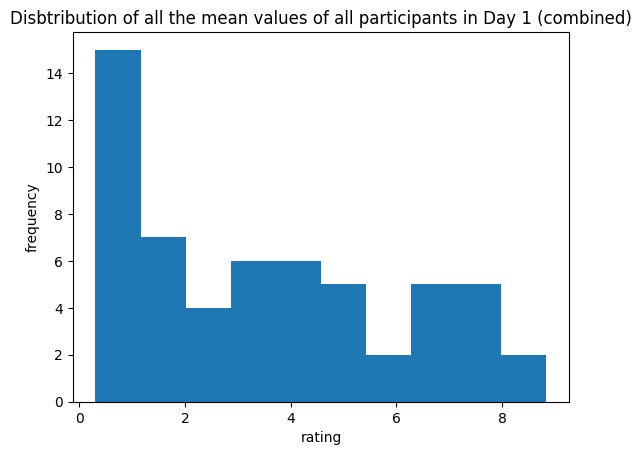

In [11]:
mean_overall = []
for i in range(len(mean_list_all)):
    mean_overall.append(np.mean(mean_list_all[i]))
plt.hist(mean_overall, bins = 10)
#plt.scatter(mean_overall, data_mean['scatter position'], c = 'black', marker = 'x', s = 0.7)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.title('Disbtribution of all the mean values of all participants in Day 1 (combined)')
plt.show()

### Variance

In [12]:
def var_all(rating):
    if len(rating) == 1:
        rating_collected = rating[0]
    elif len(rating) == 2:
        rating_collected = np.hstack([rating[0], rating[1]])
    elif len(rating) == 3:
        rating_collected = np.hstack([rating[0], rating[1], rating[2]])
    elif len(rating) == 4:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3]])
    elif len(rating) == 5:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3], rating[4]])
    else: 
        rating_collected = np.nan
    return np.var(rating_collected)

In [13]:
var_combined_list_all = []
for j in range(len(rating_downsample_list_all)):
    var_combined_list = var_all(rating_downsample_list_all[j])
    var_combined_list_all.append(var_combined_list)


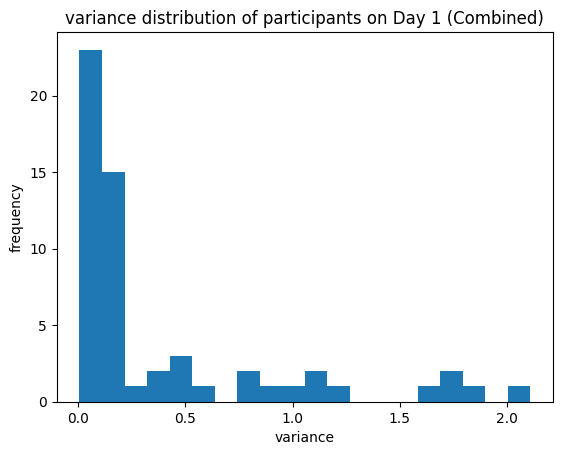

In [14]:
plt.hist(var_combined_list_all, bins = 20)
plt.xlabel('variance')
plt.ylabel('frequency')
plt.title('variance distribution of participants on Day 1 (Combined)')
plt.show()

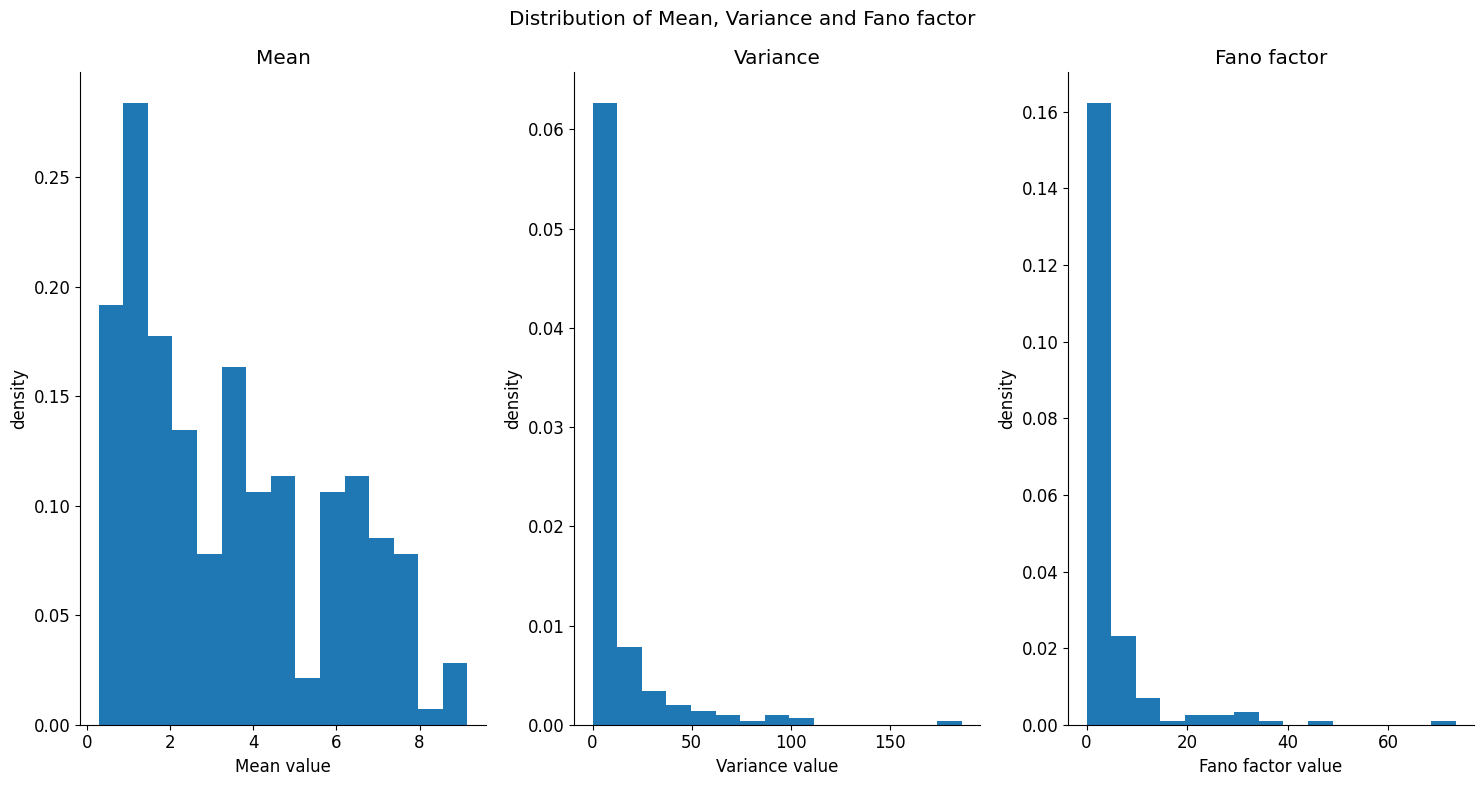

In [601]:
fig, ax = plt.subplots(1,3)

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = '20'
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels    
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
ax[0].hist(flatten(mean_list_all), density = True, bins = 15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Mean value')
ax[0].set_ylabel('density')
ax[0].set_title('Mean')
ax[1].hist(flatten(variance_list_all), density = True, bins = 15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Variance value')
ax[1].set_ylabel('density')
ax[1].set_title('Variance')
ax[2].hist(flatten(fano_factor_list_all), density = True, bins = 15)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Fano factor value')
ax[2].set_ylabel('density')
ax[2].set_title('Fano factor')
plt.suptitle('Distribution of Mean, Variance and Fano factor')
plt.tight_layout()

## Frequency
### FFT

In [81]:
rating_remove_mean = []
for i in range(len(rating_downsample_list_all)):
    rating_remove_mean.append(rating_downsample_list_all[i] - np.array(mean_list_all[i]))
removed_mean_psd_freq_list_all = []
removed_mean_psd_list_all=[]


for j in range(len(rating_downsample_list_all)):
    #plt.figure()
    removed_mean_psd_freq_list, removed_mean_psd_list = power_spectrum(rating_remove_mean[j], time_downsample_list_all[j])
    removed_mean_psd_freq_list_all.append(removed_mean_psd_freq_list)
    removed_mean_psd_list_all.append(removed_mean_psd_list)
    #for i in range(len(lowpass_list_all[j])):
        #plt.plot(psd_freq_list[i], np.abs(psd_list[i]))
    #plt.xlim(0,0.15)
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('Power Spectral Density')
    #plt.title(f'Power Spectral Density of the pain signal for \n participant {participant_list[j]}')


### Power spectrum

In [15]:
psd_freq_list_all = []
psd_list_all=[]


for j in range(len(rating_downsample_list_all)):
    #plt.figure()
    psd_freq_list, psd_list = power_spectrum(rating_downsample_list_all[j], time_downsample_list_all[j])
    psd_freq_list_all.append(psd_freq_list)
    psd_list_all.append(psd_list)
    #for i in range(len(lowpass_list_all[j])):
        #plt.plot(psd_freq_list[i], np.abs(psd_list[i]))
    #plt.xlim(0,0.15)
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('Power Spectral Density')
    #plt.title(f'Power Spectral Density of the pain signal for \n participant {participant_list[j]}')


#### power spectrum all

<Figure size 1000x1000 with 0 Axes>

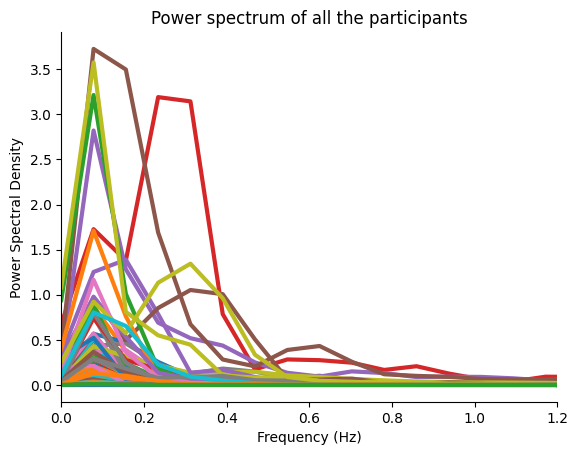

In [16]:
plt.figure(figsize = (10, 10))
fig, ax = plt.subplots()
for i in range(len(psd_freq_list_all)):
    for j in range(len(psd_freq_list_all[i])):
        ax.plot(psd_freq_list_all[i][j], np.abs(psd_list_all[i][j]), linewidth = 3)
ax.set_xlim(0,1.2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')
ax.set_title('Power spectrum of all the participants')
#ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('power_spectrum.svg')

## Permutation entropy

In [17]:
entropy_list_all = []
stat_complexity_list_all = []
for i in range(len(rating_downsample_list_all)):
    #plt.figure()
    entropy_list, stat_complexity_list = permutation_entropy(rating_downsample_list_all[i])
    entropy_list_all.append(entropy_list)
    stat_complexity_list_all.append(stat_complexity_list)
    #plt.scatter(range(1,len(entropy_list)+1), entropy_list)
    #plt.title(f'Permutation entropy of the data for \n participant {participant_list[i]}')
    #plt.xlabel('trial number')
    #plt.ylabel('permutation entropy')
    #plt.ylim(-0.1,1.1)
    #plt.xticks([1,2,3])

#### Permutation entropy all

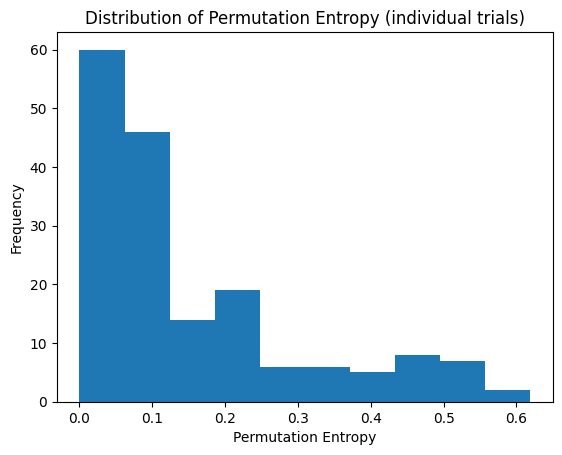

In [18]:
plt.hist(flatten(entropy_list_all))
plt.xlabel('Permutation Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Permutation Entropy (individual trials)')
plt.show()

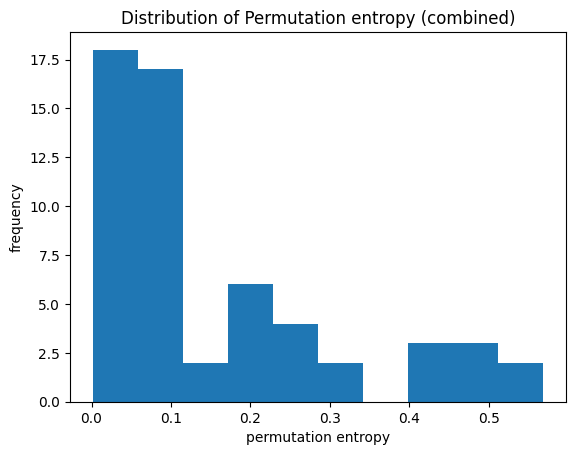

In [19]:
entropy_overall = []
for i in range(len(entropy_list_all)):
    entropy_overall.append(np.mean(entropy_list_all[i]))
plt.hist(entropy_overall)
plt.xlabel('permutation entropy')
plt.ylabel('frequency')
plt.title('Distribution of Permutation entropy (combined)')
plt.show()

## Sample Entropy

In [94]:
sample_entropy_list_all_diffm = []
for i in tqdm(range(len(rating_downsample_list_all))):
    sample_entropy_list = sample_entropy_func_default(rating_downsample_list_all[i])
    sample_entropy_list_all_diffm.append(sample_entropy_list)

  0%|          | 0/57 [00:00<?, ?it/s]

In [95]:
sample_entropy_list_all = []
for i in range(len(sample_entropy_list_all_diffm)):
    sampen_part = []
    for j in range(len(sample_entropy_list_all_diffm[i])):
        sampen_part.append(sample_entropy_list_all_diffm[i][j][2])
    sample_entropy_list_all.append(sampen_part)

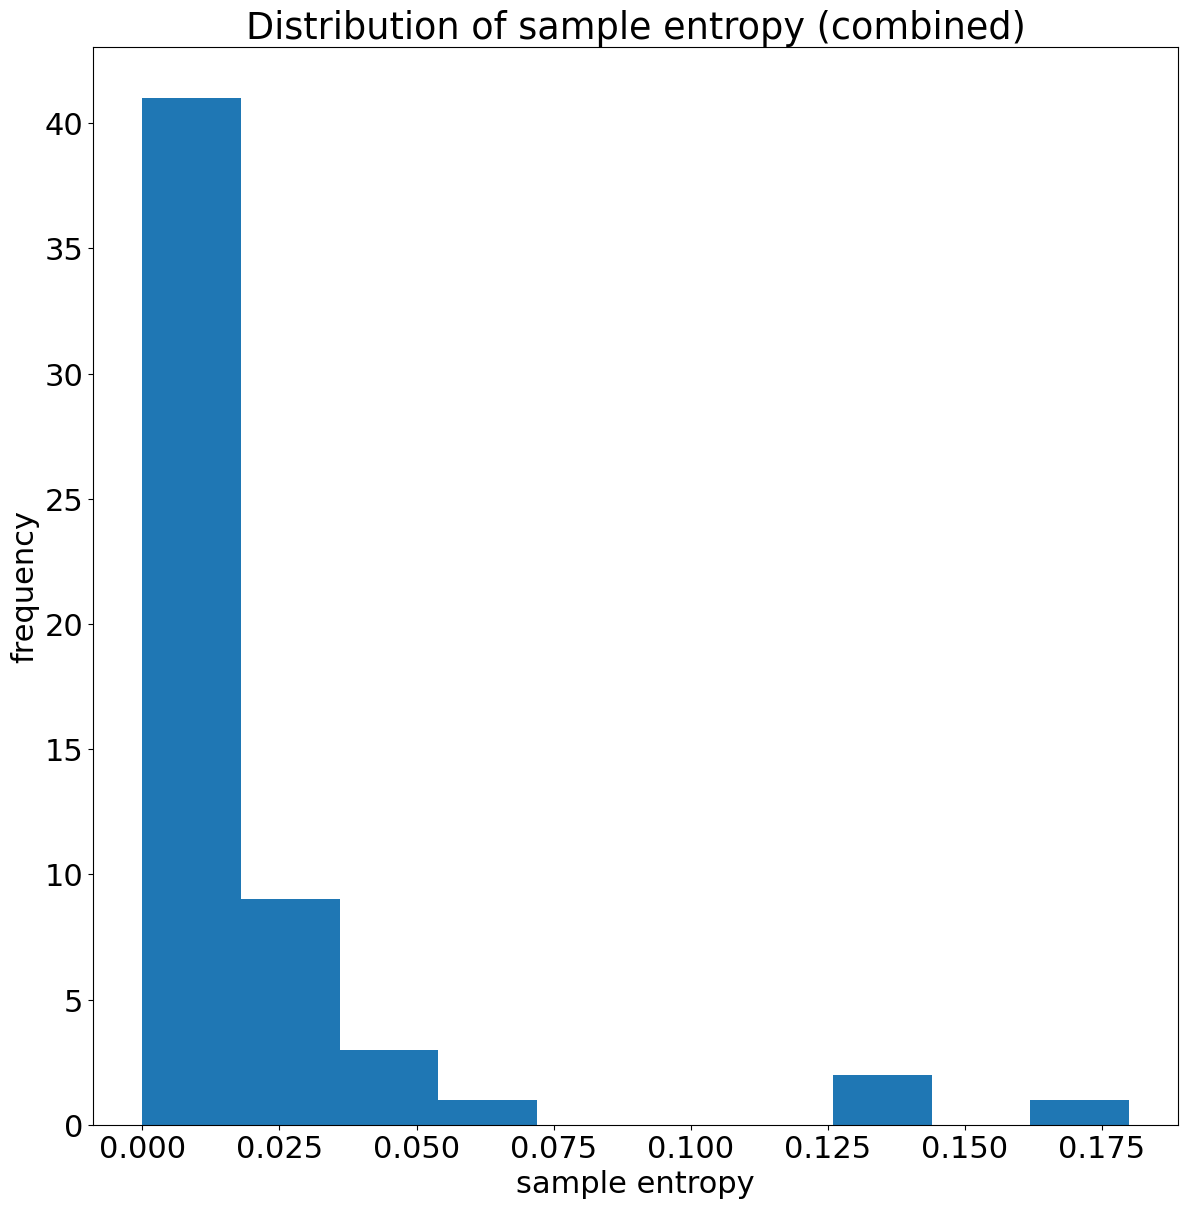

In [96]:
sample_entropy_overall = []
for i in range(len(sample_entropy_list_all)):
    sample_entropy_overall.append(np.mean(sample_entropy_list_all[i]))
plt.hist(sample_entropy_overall)
plt.xlabel('sample entropy')
plt.ylabel('frequency')
plt.title('Distribution of sample entropy (combined)')
plt.show()

## Shannon Entropy

In [22]:
def shannon_entropy(rating):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            hist, _ = np.histogram(rating[i])
            probability = hist/np.sum(hist)
            entropy_value = entropy(probability)
            entropy_list.append(entropy_value)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

In [23]:
hist, _ = np.histogram(rating_downsample_list_all[0][0])
probability = hist/np.sum(hist)
entropy(probability)

0.04337285029413908

In [24]:
shannon_entropy_list_all = []
for i in range(len(rating_downsample_list_all)):
    shannon_entropy_list = shannon_entropy(rating_downsample_list_all[i])
    shannon_entropy_list_all.append(shannon_entropy_list)

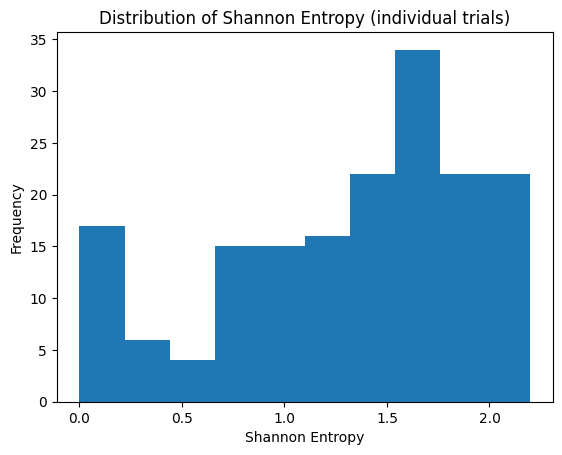

In [25]:
plt.hist(flatten(shannon_entropy_list_all))
plt.xlabel('Shannon Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Shannon Entropy (individual trials)')
plt.show()

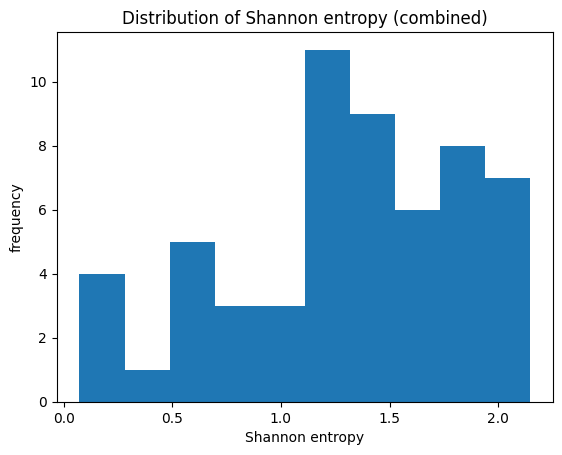

In [26]:
shannon_entropy_overall = []
for i in range(len(shannon_entropy_list_all)):
    shannon_entropy_overall.append(np.mean(shannon_entropy_list_all[i]))
plt.hist(shannon_entropy_overall)
plt.xlabel('Shannon entropy')
plt.ylabel('frequency')
plt.title('Distribution of Shannon entropy (combined)')
plt.show()

# Fractal Dimension

In [27]:
def hurst_dfa_tryhardpls(rating):
    poly_order = 1
    rating = np.random.randn(10000)#rating_all[0][0]
    window_sizes = [len(rating)//2,len(rating)//4,len(rating)//8,len(rating)//16,len(rating)//32]
    F_n_all = []
    for w in window_sizes:
        X_t = np.cumsum(np.array(rating) - np.mean(rating))
        segments = np.array_split(X_t, len(X_t)//w)
        poly_coeffs_all = []
        Y_t = []
        for i in range(len(segments)):
            poly_coeff = np.polyfit(np.arange(w), segments[i][:w], poly_order)
            poly_coeffs_all.append(poly_coeff) #slope then intercept
            Y_t_seg = poly_coeff[0]*np.arange(w)+poly_coeff[1]
            for j in range(len(Y_t_seg)):
                Y_t.append(Y_t_seg[j])
        F_n = np.sqrt(np.sum((X_t[:len(Y_t)] - np.array(Y_t))**2)/len(X_t))
        F_n_all.append(F_n)
    #plt.scatter(np.log(window_sizes),np.log(F_n_all))
    return np.polyfit(np.log(window_sizes),np.log(F_n_all),1)





(array([ 9., 12., 18., 20., 36., 25., 27., 16.,  7.,  3.]),
 array([1.37672002, 1.40937709, 1.44203416, 1.47469123, 1.5073483 ,
        1.54000538, 1.57266245, 1.60531952, 1.63797659, 1.67063366,
        1.70329073]),
 <BarContainer object of 10 artists>)

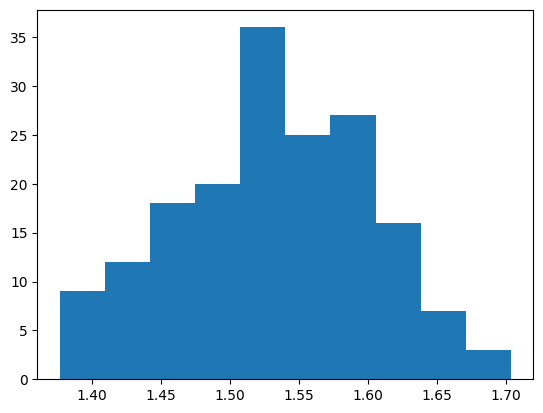

In [29]:
hurst_dfa_all_dllm = []
fractal_dfa_all_dllm = []
for i in range(len(rating_downsample_list_all)):
    hurst_dfa_list = []
    fractal_list = []
    for j in range(len(rating_downsample_list_all[i])):
        hurst_dllm = hurst_dfa_tryhardpls(rating_downsample_list_all[i][j])
        hurst_dfa_list.append(hurst_dllm[0])
        fractal_list.append(2-hurst_dllm[0])
    hurst_dfa_all_dllm.append(hurst_dfa_list)
    fractal_dfa_all_dllm.append(fractal_list)
fractal_dfa_dllm_overall = []
for i in range(len(fractal_dfa_all_dllm)):
    fractal_dfa_dllm_overall.append(np.nanmean(fractal_dfa_all_dllm[i]))
plt.hist(flatten(fractal_dfa_all_dllm))

## Check Stationarity

In [30]:
adfuller_list_all = []
stationary_list_all = []
for j in range(len(rating_downsample_list_all)):
    adfuller_list, labels, stationary_list = adfuller_test(rating_downsample_list_all[j])
    adfuller_list_all.append(adfuller_list)
    stationary_list_all.append(stationary_list)



c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\sharonho\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


## Autocorrelation

In [32]:
acorr_list_all = []
time_lag_list_all = []
for j in range(len(rating_downsample_list_all)):
        
    #plt.figure()
    acorr_list, time_lag = autocorrelation(rating_downsample_list_all[j], time_downsample_list_all[j])
    acorr_list_all.append(acorr_list)
    time_lag_list_all.append(time_lag)

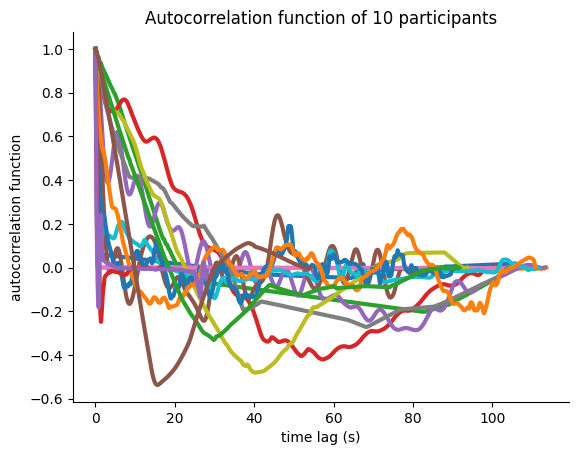

In [33]:
fig, ax = plt.subplots()
for i in range(5):
    #plt.figure()
    
    for j in range(len(time_lag_list_all[i])):
        
        ax.plot(time_lag_list_all[i][j], acorr_list_all[i][j], linewidth = 3)
        ax.set_xlabel('time lag (s)')
        ax.set_ylabel('autocorrelation function')
        ax.set_title('Autocorrelation function of 10 participants')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [34]:
char_time_scale_index = []
char_time_scale = []
for i in range(len(acorr_list_all)):
    char_time_scale_index_part = []
    char_time_scale_part = []
    for j in range(len(acorr_list_all[i])):
        time_index = np.argmax(acorr_list_all[i][j] < 0.1)
        char_time_scale_index_part.append(time_index)
        char_time_scale_part.append(time_lag_list_all[i][j][time_index])

    char_time_scale_index.append(char_time_scale_index_part)
    char_time_scale.append(char_time_scale_part)

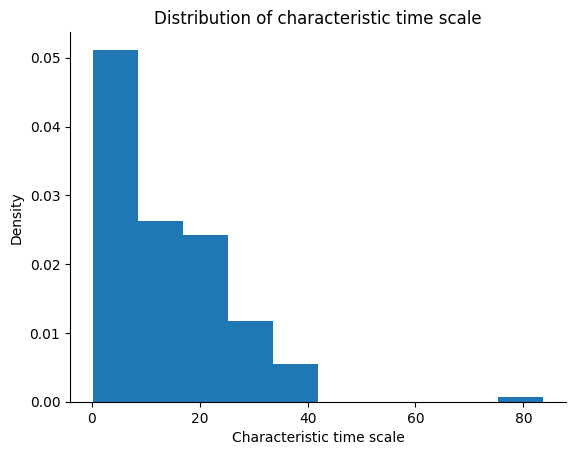

In [35]:
fig, ax = plt.subplots()
ax.hist(flatten(char_time_scale), density = True)
ax.set_title('Distribution of characteristic time scale')
ax.set_xlabel('Characteristic time scale')
ax.set_ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [36]:
char_time_scale_mean = []
for i in range(len(char_time_scale)):
    char_time_scale_mean.append(np.mean(char_time_scale[i]))
char_time_scale_mean

[6.392199999998013,
 17.692333333333323,
 16.98070000004769,
 7.222333333333329,
 6.627500000000008,
 15.598666666666665,
 8.378666666666666,
 20.77799999999999,
 13.668333333333337,
 7.0807333333492295,
 11.790666666666667,
 16.558999999999997,
 27.407333333333344,
 6.089000000000002,
 3.0699000000059393,
 2.73123333330949,
 18.92419999996821,
 3.79526666666816,
 24.953799999992057,
 0.5466666666666669,
 12.57800000000001,
 18.913133333333366,
 7.580533333333331,
 6.219366666634879,
 25.119666666666678,
 13.151666666666662,
 16.869766666670653,
 19.188333333333343,
 17.821333333333325,
 39.73766666666666,
 18.214999999999993,
 27.987300000006957,
 6.331999999999994,
 3.402250000000002,
 19.527666666666665,
 6.68880000003179,
 20.717333333333343,
 13.289666666666676,
 0.3776999999980101,
 10.398133333325381,
 1.133100000063583,
 23.498000000000015,
 23.092000000000002,
 6.83923333333928,
 13.49666666666667,
 6.851200000007945,
 21.78460000000398,
 12.79126666665077,
 6.0882333333332825

Text(0.5, 1.0, 'Autocorrelation function of all the participants')

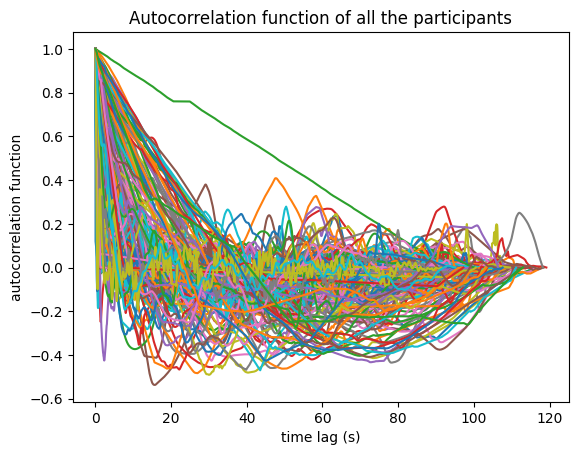

In [37]:
for i in range(len(time_lag_list_all)):
    for j in range(len(time_lag_list_all[i])):
        plt.plot(time_lag_list_all[i][j], acorr_list_all[i][j])
plt.xlabel('time lag (s)')
plt.ylabel('autocorrelation function')
plt.title('Autocorrelation function of all the participants')

# CV

In [38]:
def cv(rating):
    cv_list = []
    for i in range(len(rating)):
        cv_list.append(np.std(rating[i])/np.mean(rating[i]))
    return cv_list
    

In [39]:
cv_list_all = []

for j in range(len(rating_downsample_list_all)):
        cv_list = cv(rating_downsample_list_all[j])
        cv_list_all.append(cv_list)
        
        


(array([119.,  31.,  11.,   6.,   2.,   0.,   0.,   2.,   1.,   1.]),
 array([5.07665718e-16, 1.78164275e-01, 3.56328551e-01, 5.34492826e-01,
        7.12657102e-01, 8.90821377e-01, 1.06898565e+00, 1.24714993e+00,
        1.42531420e+00, 1.60347848e+00, 1.78164275e+00]),
 <BarContainer object of 10 artists>)

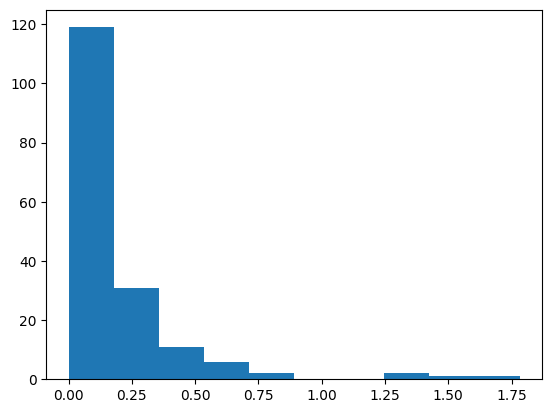

In [40]:
plt.hist(flatten(cv_list_all))

In [41]:
def cv_all(rating):
    if len(rating) == 1:
        rating_collected = rating[0]
    elif len(rating) == 2:
        rating_collected = np.hstack([rating[0], rating[1]])
    elif len(rating) == 3:
        rating_collected = np.hstack([rating[0], rating[1], rating[2]])
    elif len(rating) == 4:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3]])
    elif len(rating) == 5:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3], rating[4]])
    else: 
        rating_collected = np.nan
    return np.std(rating_collected)/np.mean(rating_collected)

In [42]:
cv_combined_list = []
for j in range(len(rating_downsample_list_all)):
    cv_list = cv_all(rating_downsample_list_all[j])
    cv_combined_list.append(cv_list)

In [43]:
cv_combined_list

[0.7704598235855347,
 0.05474881507339307,
 0.5926022161706661,
 0.10822625485764938,
 0.04949922038295437,
 0.0872071756462822,
 0.2625172858105838,
 0.22680359647940454,
 0.3204696845565399,
 0.8489933004702406,
 0.5500599285730107,
 0.10126423468000284,
 0.21755128193611123,
 0.1167863569048886,
 0.13843298826747263,
 0.7693707843729937,
 0.12182011289222915,
 1.3441273970253513,
 0.08057822724638956,
 0.08733692900662363,
 0.05297153169798693,
 0.25024979402180264,
 0.04497177952572099,
 0.0757629758248237,
 0.05282696998145316,
 0.06337351601626476,
 0.25878525399008384,
 0.10154019691018157,
 0.21116055505446502,
 0.05231812550277226,
 0.04416676683735542,
 0.09580890381395865,
 0.299544384414262,
 0.20238809838260596,
 0.038961288880282274,
 0.29723435039000323,
 0.03654300309972862,
 0.2973824033708388,
 0.4557708419629787,
 0.303717683593222,
 0.2296304290305011,
 0.26790386120455995,
 0.07669962125763707,
 0.4521928701313717,
 0.2873721333621157,
 0.17415341505708976,
 0.0306

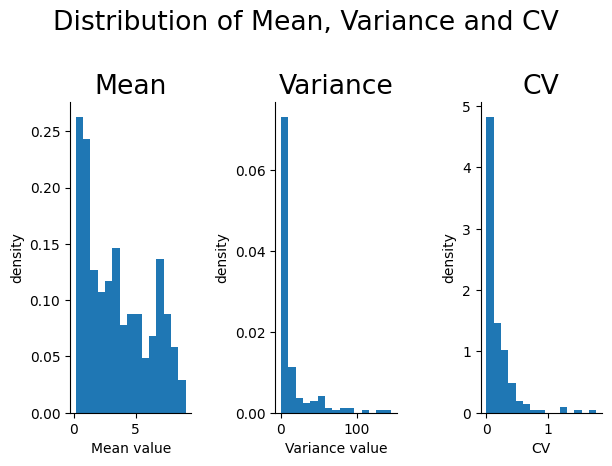

In [44]:
fig, ax = plt.subplots(1,3)

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = '16'
ax[0].hist(flatten(mean_list_all), density = True, bins = 15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Mean value')
ax[0].set_ylabel('density')
ax[0].set_title('Mean')
ax[1].hist(flatten(variance_list_all), density = True, bins = 15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Variance value')
ax[1].set_ylabel('density')
ax[1].set_title('Variance')
ax[2].hist(flatten(cv_list_all), density = True, bins = 15)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('CV')
ax[2].set_ylabel('density')
ax[2].set_title('CV')
plt.suptitle('Distribution of Mean, Variance and CV')
plt.tight_layout()

## Try analysis
### Mean pain VS PE

### MSK scores and Mean

In [46]:
#list all the data files and its path
questionnaire = []
onlyfiles = [f for f in listdir('../Data/questionnaire') if isfile(join('../Data/questionnaire', f))]
for i in range(len(onlyfiles)):
    path = '../Data/questionnaire/' + onlyfiles[i]
    questionnaire.append(path)

questionnaire

df_questionnaire_pre = pd.read_csv(questionnaire[0])
df_questionnaire_s1 = pd.read_csv(questionnaire[1])
df_questionnaire_s2 = pd.read_csv(questionnaire[2])

In [47]:
index_pre = []
for id in participant_list_d2:
    index_pre.append(np.where(df_questionnaire_pre.PROLIFIC_PID == id)[0][0])
index_s1 = []
for id in participant_list_d2:
    index_s1.append(np.where(df_questionnaire_s1.PROLIFIC_PID == id)[0])
index_s2 = []
for id in participant_list_d2:
    index_s2.append(np.where(df_questionnaire_s2.PROLIFIC_PID == id)[0])

In [48]:
df_questionnaire_index_pre = df_questionnaire_pre.iloc[index_pre]
msk_scores = df_questionnaire_index_pre['Score'].values

In [50]:
print('mean')
mean_mskscores = zip(mean_overall, msk_scores)
x = []; y=[]
for point in list(mean_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_mean_mskscores = np.corrcoef(x,y)
print(corr_mean_mskscores)
msk_bf = []
bf_mean_msk = pingouin.bayesfactor_pearson(corr_mean_mskscores[0][1], len(x))
msk_bf.append(bf_mean_msk)
print(bf_mean_msk)

print('---------')
print('variance')
var_mskscores = zip(var_combined_list_all, msk_scores)
x = []; y=[]
for point in list(var_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_var_mskscores = np.corrcoef(x,y)
print(corr_var_mskscores)
bf_var_msk = pingouin.bayesfactor_pearson(corr_var_mskscores[0][1], len(x))
msk_bf.append(bf_var_msk)
print(bf_var_msk)


print('---------')
print('CV')
fano_mskscores = zip(cv_combined_list, msk_scores)
x = []; y=[]
for point in list(fano_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fano_mskscores = np.corrcoef(x,y)
print(corr_fano_mskscores)
bf_fano_msk = pingouin.bayesfactor_pearson(corr_fano_mskscores[0][1], len(x))
msk_bf.append(bf_fano_msk)
print(bf_fano_msk)

print('---------')
print('Shannon Entropy')
shannon_mskscores = zip(shannon_entropy_overall, msk_scores)
x = []; y=[]
for point in list(shannon_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_shannon_mskscores = np.corrcoef(x,y)
print(corr_shannon_mskscores)
bf_shannon_msk = pingouin.bayesfactor_pearson(corr_shannon_mskscores[0][1], len(x))
msk_bf.append(bf_shannon_msk)
print(bf_shannon_msk)

print('---------')
print('PE')
pe_mskscores = zip(entropy_overall, msk_scores)
x = []; y=[]
for point in list(pe_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_pe_mskscores = np.corrcoef(x,y)
print(corr_pe_mskscores)
bf_entropy_msk = pingouin.bayesfactor_pearson(corr_pe_mskscores[0][1], len(x))
msk_bf.append(bf_entropy_msk)
print(bf_entropy_msk)

print('---------')
print('SampEn')
sampen_mskscores = zip(sample_entropy_overall, msk_scores)
x = []; y=[]
for point in list(sampen_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sampen_mskscores = np.corrcoef(x,y)
print(corr_sampen_mskscores)
bf_sampen_msk = pingouin.bayesfactor_pearson(corr_sampen_mskscores[0][1], len(x))
msk_bf.append(bf_sampen_msk)
print(bf_sampen_msk)

print('---------')
print('acf')
acf_mskscores = zip(char_time_scale_mean, msk_scores)
x = []; y=[]
for point in list(acf_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_acf_mskscores = np.corrcoef(x,y)
print(corr_acf_mskscores)
bf_acf_msk = pingouin.bayesfactor_pearson(corr_acf_mskscores[0][1], len(x))
msk_bf.append(bf_acf_msk)
print(bf_acf_msk)

print('---------')
print('fractal')
fractal_mskscores = zip(fractal_dfa_dllm_overall, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
msk_bf.append(bf_fractal_msk)
print(bf_fractal_msk)






mean
[[ 1.         -0.63187849]
 [-0.63187849  1.        ]]
124969.9692237815
---------
variance
[[ 1.         -0.15561756]
 [-0.15561756  1.        ]]
0.3170721595749712
---------
CV
[[1.         0.30855221]
 [0.30855221 1.        ]]
2.35941347512396
---------
Shannon Entropy
[[ 1.         -0.14113229]
 [-0.14113229  1.        ]]
0.2821163661292443
---------
PE
[[ 1.         -0.04661279]
 [-0.04661279  1.        ]]
0.1751147695784194
---------
SampEn
[[1.         0.00464492]
 [0.00464492 1.        ]]
0.16537384775118094
---------
acf
[[ 1.         -0.34273861]
 [-0.34273861  1.        ]]
4.574086223236979
---------
fractal
[[1.         0.28508146]
 [0.28508146 1.        ]]
1.5720371795653287


"\nprint('---------')\nprint('smape')\nsmape_mskscores = zip(smape_mean_all, msk_scores)\nx = []; y=[]\nfor point in list(smape_mskscores):\n   x.append(point[0])\n   y.append(point[1])\nfor i in range(len(y)):\n   if pd.isnull(y[i]):\n      x[i] = np.NaN\n   if pd.isnull(x[i]):\n      y[i] = np.NaN\nx = pd.Series(x).dropna().to_list()\ny = pd.Series(y).dropna().to_list()\na, b = np.polyfit(x, y, 1)\ncorr_smape_mskscores = np.corrcoef(x,y)\nprint(corr_smape_mskscores)\nbf_smape_msk = pingouin.bayesfactor_pearson(corr_smape_mskscores[0][1], len(x))\nmsk_bf.append(bf_smape_msk)\nprint(bf_smape_msk)\n"

In [51]:

msk_last_q_corr = np.load('msk_last_q.npy')
print('mean')
mean_mskscores_lastq = zip(mean_overall, msk_last_q_corr)
x = []; y=[]
for point in list(mean_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_mean_mskscores_lastq = np.corrcoef(x,y)
print(corr_mean_mskscores_lastq)
msk_lastq_bf = []
bf_mean_msk_lastq = pingouin.bayesfactor_pearson(corr_mean_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_mean_msk_lastq)
print(bf_mean_msk_lastq)

print('---------')
print('variance')
var_mskscores_lastq = zip(var_combined_list_all, msk_last_q_corr)
x = []; y=[]
for point in list(var_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_var_mskscores_lastq = np.corrcoef(x,y)
print(corr_var_mskscores_lastq)
bf_var_msk_lastq = pingouin.bayesfactor_pearson(corr_var_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_var_msk_lastq)
print(bf_var_msk_lastq)


print('---------')
print('CV')
fano_mskscores_lastq = zip(cv_combined_list, msk_last_q_corr)
x = []; y=[]
for point in list(fano_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fano_mskscores_lastq = np.corrcoef(x,y)
print(corr_fano_mskscores_lastq)
bf_fano_msk_lastq = pingouin.bayesfactor_pearson(corr_fano_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_fano_msk_lastq)
print(bf_fano_msk_lastq)

print('---------')
print('Shannon Entropy')
shannon_mskscores_lastq = zip(shannon_entropy_overall, msk_last_q_corr)
x = []; y=[]
for point in list(shannon_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_shannon_mskscores_lastq = np.corrcoef(x,y)
print(corr_shannon_mskscores_lastq)
bf_shannon_msk_lastq = pingouin.bayesfactor_pearson(corr_shannon_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_shannon_msk_lastq)
print(bf_shannon_msk_lastq)

print('---------')
print('PE')
pe_mskscores_lastq = zip(entropy_overall, msk_last_q_corr)
x = []; y=[]
for point in list(pe_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_pe_mskscores_lastq = np.corrcoef(x,y)
print(corr_pe_mskscores_lastq)
bf_entropy_msk_lastq = pingouin.bayesfactor_pearson(corr_pe_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_entropy_msk_lastq)
print(bf_entropy_msk_lastq)

print('---------')
print('SampEn')
sampen_mskscores_lastq = zip(sample_entropy_overall, msk_last_q_corr)
x = []; y=[]
for point in list(sampen_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sampen_mskscores_lastq = np.corrcoef(x,y)
print(corr_sampen_mskscores_lastq)
bf_sampen_msk_lastq = pingouin.bayesfactor_pearson(corr_sampen_mskscores[0][1], len(x))
msk_lastq_bf.append(bf_sampen_msk_lastq)
print(bf_sampen_msk_lastq)

print('---------')
print('acf')
acf_mskscores_lastq = zip(char_time_scale_mean, msk_last_q_corr)
x = []; y=[]
for point in list(acf_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_acf_mskscores_lastq = np.corrcoef(x,y)
print(corr_acf_mskscores_lastq)
bf_acf_msk_lastq = pingouin.bayesfactor_pearson(corr_acf_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_acf_msk_lastq)
print(bf_acf_msk_lastq)

print('---------')
print('fractal')
fractal_mskscores_lastq = zip(fractal_dfa_dllm_overall, msk_last_q_corr)
x = []; y=[]
for point in list(fractal_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_mskscores_lastq = np.corrcoef(x,y)
print(corr_fractal_mskscores_lastq)
bf_fractal_msk_lastq = pingouin.bayesfactor_pearson(corr_fractal_mskscores_lastq[0][1], len(x))
msk_lastq_bf.append(bf_fractal_msk_lastq)
print(bf_fractal_msk_lastq)






mean
[[1.         0.03636835]
 [0.03636835 1.        ]]
0.17119611352897576
---------
variance
[[1.         0.11031998]
 [0.11031998 1.        ]]
0.22884871074459762
---------
CV
[[1.         0.04271284]
 [0.04271284 1.        ]]
0.1734977829765323
---------
Shannon Entropy
[[1.         0.28382738]
 [0.28382738 1.        ]]
1.5399442823553213
---------
PE
[[1.         0.27174934]
 [0.27174934 1.        ]]
1.2693806650877382
---------
SampEn
[[1.         0.16361376]
 [0.16361376 1.        ]]
0.16537384775118094
---------
acf
[[1.        0.0364167]
 [0.0364167 1.       ]]
0.17121214651953157
---------
fractal
[[1.        0.0897719]
 [0.0897719 1.       ]]
0.20493211967889857


Clinical questionnaires
* BPI mean severity
* BPI mean interference
* Total START
* START subscore
* Total PCS score
* PCS rumination
* PCS magnification 
* PCS helplessness
* Total GAD7
* Total PHQ9


use mean, variance and permutation entropy to correlate with all these

In [52]:
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])

In [54]:
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list_d2)):
    if participant_list_d2[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_overall)[s1_questionnaire_index]
var_s1 = np.array(var_combined_list_all)[s1_questionnaire_index]
entropy_s1 = np.array(entropy_overall)[s1_questionnaire_index]
cv_s1 = np.array(cv_combined_list)[s1_questionnaire_index]
shannon_entropy_s1 = np.array(shannon_entropy_overall)[s1_questionnaire_index]
acf_s1 = np.array(char_time_scale_mean)[s1_questionnaire_index]
fractal_s1 = np.array(fractal_dfa_dllm_overall)[s1_questionnaire_index]
sample_entropy_s1 = np.array(sample_entropy_overall)[s1_questionnaire_index]


### BPI mean severity

In [55]:
print('mean')
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
mean_bpisev = zip(mean_s1, bpi_mean_severity)
x = []; y=[]
for point in list(mean_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_mean_bpisev = np.corrcoef(x,y)
print(corr_mean_bpisev)
bpisev_bf = []
bf_mean_bpisev = pingouin.bayesfactor_pearson(corr_mean_bpisev[0][1], len(x))
bpisev_bf.append(bf_mean_bpisev)
print(bf_mean_bpisev)
print('------')
print('variance')
var_bpisev = zip(var_s1, bpi_mean_severity)
x = []; y=[]
for point in list(var_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_var_bpisev = np.corrcoef(x,y)
print(corr_var_bpisev)
bf_var_bpisev = pingouin.bayesfactor_pearson(corr_var_bpisev[0][1], len(x))
bpisev_bf.append(bf_var_bpisev)
print(bf_var_bpisev)

print('------')
print('CV')
fano_bpisev = zip(cv_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fano_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fano_bpisev = np.corrcoef(x,y)
print(corr_fano_bpisev)
bf_fano_bpisev = pingouin.bayesfactor_pearson(corr_fano_bpisev[0][1], len(x))
bpisev_bf.append(bf_fano_bpisev)
print(bf_fano_bpisev)

print('------')
print('Shannon Entropy')
shannon_entropy_bpisev = zip(shannon_entropy_s1, bpi_mean_severity)
x = []; y=[]
for point in list(shannon_entropy_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_shannon_entropy_bpisev = np.corrcoef(x,y)
print(corr_shannon_entropy_bpisev)
bf_shannon_entropy_bpisev = pingouin.bayesfactor_pearson(corr_shannon_entropy_bpisev[0][1], len(x))
bpisev_bf.append(bf_shannon_entropy_bpisev)
print(bf_shannon_entropy_bpisev)
print('------')
print('PE')
entropy_bpisev = zip(entropy_s1, bpi_mean_severity)
x = []; y=[]
for point in list(entropy_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_entropy_bpisev = np.corrcoef(x,y)
print(corr_entropy_bpisev)
bf_entropy_bpisev = pingouin.bayesfactor_pearson(corr_entropy_bpisev[0][1], len(x))
bpisev_bf.append(bf_entropy_bpisev)
print(bf_entropy_bpisev)

print('------')
print('SampEn')
sample_entropy_bpisev = zip(sample_entropy_s1, bpi_mean_severity)
x = []; y=[]
for point in list(sample_entropy_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_sample_entropy_bpisev = np.corrcoef(x,y)
print(corr_sample_entropy_bpisev)
bf_sample_entropy_bpisev = pingouin.bayesfactor_pearson(corr_sample_entropy_bpisev[0][1], len(x))
bpisev_bf.append(bf_sample_entropy_bpisev)
print(bf_sample_entropy_bpisev)

print('------')
print('ACF')
acf_bpisev = zip(acf_s1, bpi_mean_severity)
x = []; y=[]
for point in list(acf_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_acf_bpisev = np.corrcoef(x,y)
print(corr_acf_bpisev)
bf_acf_bpisev = pingouin.bayesfactor_pearson(corr_acf_bpisev[0][1], len(x))
bpisev_bf.append(bf_acf_bpisev)
print(bf_acf_bpisev)

print('------')
print('fractal')
fractal_bpisev = zip(fractal_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
bpisev_bf.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)


mean
[[1.         0.73842728]
 [0.73842728 1.        ]]
9401496.816953087
------
variance
[[1.         0.06554806]
 [0.06554806 1.        ]]
0.19632954914907735
------
CV
[[ 1.         -0.44122605]
 [-0.44122605  1.        ]]
23.660869176914222
------
Shannon Entropy
[[ 1.         -0.00684311]
 [-0.00684311  1.        ]]
0.17832229980924696
------
PE
[[ 1.         -0.17166789]
 [-0.17166789  1.        ]]
0.35008617511499446
------
SampEn
[[ 1.         -0.22315331]
 [-0.22315331  1.        ]]
0.5646726177364958
------
ACF
[[1.         0.29338282]
 [0.29338282 1.        ]]
1.360072240368233
------
fractal
[[1.         0.05916856]
 [0.05916856 1.        ]]
0.19281914216385584


### BPI mean pain interference

In [56]:
print('mean')
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
mean_bpiint = zip(mean_s1, bpi_mean_interference)
x = []; y=[]
for point in list(mean_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_mean_bpiint = np.corrcoef(x,y)
print(corr_mean_bpiint)
bpiint_bf = []
bf_mean_bpiint = pingouin.bayesfactor_pearson(corr_mean_bpiint[0][1], len(x))
bpiint_bf.append(bf_mean_bpiint)
print(bf_mean_bpiint)

print('------')
print('variance')
var_bpiint = zip(var_s1, bpi_mean_interference)
x = []; y=[]
for point in list(var_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_var_bpiint = np.corrcoef(x,y)
print(corr_var_bpiint)
bf_var_bpiint = pingouin.bayesfactor_pearson(corr_var_bpiint[0][1], len(x))
bpiint_bf.append(bf_var_bpiint)
print(bf_var_bpiint)


print('------')
print('CV')
fano_bpiint = zip(cv_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fano_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fano_bpiint = np.corrcoef(x,y)
print(corr_fano_bpiint)
bf_fano_bpiint = pingouin.bayesfactor_pearson(corr_fano_bpiint[0][1], len(x))
bpiint_bf.append(bf_fano_bpiint)
print(bf_fano_bpiint)

print('------')
print('Shannon Entropy')
shannon_entropy_bpiint = zip(shannon_entropy_s1, bpi_mean_interference)
x = []; y=[]
for point in list(shannon_entropy_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_shannon_entropy_bpiint = np.corrcoef(x,y)
print(corr_shannon_entropy_bpiint)
bf_shannon_entropy_bpiint = pingouin.bayesfactor_pearson(corr_shannon_entropy_bpiint[0][1], len(x))
bpiint_bf.append(bf_shannon_entropy_bpiint)
print(bf_shannon_entropy_bpiint)

print('------')
print('PE')
entropy_bpiint = zip(entropy_s1, bpi_mean_interference)
x = []; y=[]
for point in list(entropy_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_entropy_bpiint = np.corrcoef(x,y)
print(corr_entropy_bpiint)
bf_entropy_bpiint = pingouin.bayesfactor_pearson(corr_entropy_bpiint[0][1], len(x))
bpiint_bf.append(bf_entropy_bpiint)
print(bf_entropy_bpiint)

print('------')
print('SampEn')
sample_entropy_bpiint = zip(sample_entropy_s1, bpi_mean_interference)
x = []; y=[]
for point in list(sample_entropy_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_sample_entropy_bpiint = np.corrcoef(x,y)
print(corr_sample_entropy_bpiint)
bf_sample_entropy_bpiint = pingouin.bayesfactor_pearson(corr_sample_entropy_bpiint[0][1], len(x))
bpiint_bf.append(bf_sample_entropy_bpiint)
print(bf_sample_entropy_bpiint)

print('------')
print('acf')
acf_bpiint = zip(acf_s1, bpi_mean_interference)
x = []; y=[]
for point in list(acf_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_acf_bpiint = np.corrcoef(x,y)
print(corr_acf_bpiint)
bf_acf_bpiint = pingouin.bayesfactor_pearson(corr_acf_bpiint[0][1], len(x))
bpiint_bf.append(bf_acf_bpiint)
print(bf_acf_bpiint)

print('------')
print('fractal')
fractal_bpiint = zip(fractal_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
bpiint_bf.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)

mean
[[1.         0.71160936]
 [0.71160936 1.        ]]
1478252.2268129003
------
variance
[[1.         0.15915591]
 [0.15915591 1.        ]]
0.3180012604221073
------
CV
[[ 1.         -0.35990103]
 [-0.35990103  1.        ]]
4.085859143055153
------
Shannon Entropy
[[1.         0.07404538]
 [0.07404538 1.        ]]
0.20168747721308627
------
PE
[[ 1.         -0.05055962]
 [-0.05055962  1.        ]]
0.18873618871077133
------
SampEn
[[ 1.         -0.13272211]
 [-0.13272211  1.        ]]
0.2661245700168139
------
acf
[[1.         0.29391946]
 [0.29391946 1.        ]]
1.3707068928674138
------
fractal
[[ 1.         -0.12257656]
 [-0.12257656  1.        ]]
0.25075848222206076


### Total START

In [57]:
back_pain = df_s1_normal['Back Pain'].values == 'Yes'

In [58]:
print('mean')
start_total = df_s1_normal['START total score'].iloc[back_pain].values
mean_start = zip(mean_s1[back_pain], start_total)
x = []; y=[]
for point in list(mean_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_start = np.corrcoef(x,y)
print(corr_mean_start)
start_bf = []
bf_mean_start = pingouin.bayesfactor_pearson(corr_mean_start[0][1], len(x))
start_bf.append(bf_mean_start)
print(bf_mean_start)
print('-----')
print('variance')
var_start = zip(var_s1[back_pain], start_total)
x = []; y=[]
for point in list(var_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_start = np.corrcoef(x,y)
print(corr_var_start)
bf_var_start = pingouin.bayesfactor_pearson(corr_var_start[0][1], len(x))
start_bf.append(bf_var_start)
print(bf_var_start)

print('-----')
print('CV')
fano_start = zip(cv_s1[back_pain], start_total)
x = []; y=[]
for point in list(fano_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_start = np.corrcoef(x,y)
print(corr_fano_start)
bf_fano_start = pingouin.bayesfactor_pearson(corr_fano_start[0][1], len(x))
start_bf.append(bf_fano_start)
print(bf_fano_start)

print('-----')
print('Shannon entropy')
shannon_entropy_start = zip(shannon_entropy_s1[back_pain], start_total)
x = []; y=[]
for point in list(shannon_entropy_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_start = np.corrcoef(x,y)
print(corr_shannon_entropy_start)
bf_shannon_entropy_start = pingouin.bayesfactor_pearson(corr_shannon_entropy_start[0][1], len(x))
start_bf.append(bf_shannon_entropy_start)
print(bf_shannon_entropy_start)

print('-----')
print('PE')
entropy_start = zip(entropy_s1[back_pain], start_total)
x = []; y=[]
for point in list(entropy_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_start = np.corrcoef(x,y)
print(corr_entropy_start)
bf_entropy_start = pingouin.bayesfactor_pearson(corr_entropy_start[0][1], len(x))
start_bf.append(bf_entropy_start)
print(bf_entropy_start)

print('-----')
print('SampEn')
sample_entropy_start = zip(sample_entropy_s1[back_pain], start_total)
x = []; y=[]
for point in list(sample_entropy_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_start = np.corrcoef(x,y)
print(corr_sample_entropy_start)
bf_sample_entropy_start = pingouin.bayesfactor_pearson(corr_sample_entropy_start[0][1], len(x))
start_bf.append(bf_sample_entropy_start)
print(bf_sample_entropy_start)

print('-----')
print('acf')
acf_start = zip(acf_s1[back_pain], start_total)
x = []; y=[]
for point in list(acf_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_start = np.corrcoef(x,y)
print(corr_acf_start)
bf_acf_start = pingouin.bayesfactor_pearson(corr_acf_start[0][1], len(x))
start_bf.append(bf_acf_start)
print(bf_acf_start)

print('-----')
print('fractal')
fractal_start = zip(fractal_s1[back_pain], start_total)
x = []; y=[]
for point in list(fractal_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
start_bf.append(bf_fractal_start)
print(bf_fractal_start)



mean
[[1.         0.58314854]
 [0.58314854 1.        ]]
64.05253709917503
-----
variance
[[1.         0.17947424]
 [0.17947424 1.        ]]
0.34894146008691246
-----
CV
[[ 1.         -0.26539351]
 [-0.26539351  1.        ]]
0.6043611029065626
-----
Shannon entropy
[[1.         0.05639864]
 [0.05639864 1.        ]]
0.2332085526919508
-----
PE
[[1.         0.07269917]
 [0.07269917 1.        ]]
0.24002666711613393
-----
SampEn
[[ 1.         -0.23270979]
 [-0.23270979  1.        ]]
0.47700949865433917
-----
acf
[[1.         0.27276711]
 [0.27276711 1.        ]]
0.6406445310722909
-----
fractal
[[ 1.         -0.18245154]
 [-0.18245154  1.        ]]
0.3542814912133833


### START subscore

In [59]:
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
print('mean')
mean_startsub = zip(mean_s1, start_sub)
x = []; y=[]
for point in list(mean_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_startsub = np.corrcoef(x,y)
print(corr_mean_startsub)
startsub_bf = []
bf_mean_startsub = pingouin.bayesfactor_pearson(corr_mean_startsub[0][1], len(x))
startsub_bf.append(bf_mean_startsub)
print(bf_mean_startsub)
print('-----')
print('variance')
var_startsub = zip(var_s1, start_sub)
x = []; y=[]
for point in list(var_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_startsub = np.corrcoef(x,y)
print(corr_var_startsub)
bf_var_startsub = pingouin.bayesfactor_pearson(corr_var_startsub[0][1], len(x))
startsub_bf.append(bf_var_startsub)
print(bf_var_startsub)

print('-----')
print('CV')
fano_startsub = zip(cv_s1, start_sub)
x = []; y=[]
for point in list(fano_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_startsub = np.corrcoef(x,y)
print(corr_fano_startsub)
bf_fano_startsub = pingouin.bayesfactor_pearson(corr_fano_startsub[0][1], len(x))
startsub_bf.append(bf_fano_startsub)
print(bf_fano_startsub)
print('-----')
print('Shannon entropy')
shannon_entropy_startsub = zip(shannon_entropy_s1, start_sub)
x = []; y=[]
for point in list(shannon_entropy_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_startsub = np.corrcoef(x,y)
print(corr_shannon_entropy_startsub)
bf_shannon_entropy_startsub = pingouin.bayesfactor_pearson(corr_shannon_entropy_startsub[0][1], len(x))
startsub_bf.append(bf_shannon_entropy_startsub)
print(bf_shannon_entropy_startsub)

print('-----')
print('PE')
entropy_startsub = zip(entropy_s1, start_sub)
x = []; y=[]
for point in list(entropy_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_startsub = np.corrcoef(x,y)
print(corr_entropy_startsub)
bf_entropy_startsub = pingouin.bayesfactor_pearson(corr_entropy_startsub[0][1], len(x))
startsub_bf.append(bf_entropy_startsub)
print(bf_entropy_startsub)

print('-----')
print('SampEn')
sample_entropy_startsub = zip(sample_entropy_s1, start_sub)
x = []; y=[]
for point in list(sample_entropy_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_startsub = np.corrcoef(x,y)
print(corr_sample_entropy_startsub)
bf_sample_entropy_startsub = pingouin.bayesfactor_pearson(corr_sample_entropy_startsub[0][1], len(x))
startsub_bf.append(bf_sample_entropy_startsub)
print(bf_sample_entropy_startsub)

print('-----')
print('acf')
acf_startsub = zip(acf_s1, start_sub)
x = []; y=[]
for point in list(acf_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_startsub = np.corrcoef(x,y)
print(corr_acf_startsub)
bf_acf_startsub = pingouin.bayesfactor_pearson(corr_acf_startsub[0][1], len(x))
startsub_bf.append(bf_acf_startsub)
print(bf_acf_startsub)
print('-----')
print('fractal')
fractal_startsub = zip(fractal_s1, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
startsub_bf.append(bf_fractal_startsub)
print(bf_fractal_startsub)


mean
[[1.         0.23270829]
 [0.23270829 1.        ]]
0.47700468526247364
-----
variance
[[1.         0.14000923]
 [0.14000923 1.        ]]
0.2924904007971533
-----
CV
[[1.         0.15986626]
 [0.15986626 1.        ]]
0.31782244210686905
-----
Shannon entropy
[[1.         0.00182038]
 [0.00182038 1.        ]]
0.2233042292067966
-----
PE
[[1.         0.09530219]
 [0.09530219 1.        ]]
0.25287713661911015
-----
SampEn
[[1.         0.07530963]
 [0.07530963 1.        ]]
0.24130158246147018
-----
acf
[[ 1.         -0.12677911]
 [-0.12677911  1.        ]]
0.27850416142659234
-----
fractal
[[1.         0.19935281]
 [0.19935281 1.        ]]
0.3881516119052707


### Total PCS Score

In [60]:
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list_d2)):
    if participant_list_d2[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_overall)[s2_questionnaire_index]
var_s2 = np.array(var_combined_list_all)[s2_questionnaire_index]
entropy_s2 = np.array(entropy_overall)[s2_questionnaire_index]
cv_s2 = np.array(cv_combined_list)[s2_questionnaire_index]
shannon_entropy_s2 = np.array(shannon_entropy_overall)[s2_questionnaire_index]
acf_s2 = np.array(char_time_scale_mean)[s2_questionnaire_index]
fractal_s2 = np.array(fractal_dfa_dllm_overall)[s2_questionnaire_index]
sample_entropy_s2 = np.array(sample_entropy_overall)[s2_questionnaire_index]


In [61]:
pcs_total = df_s2_normal['Total PCS Score'].values
print('mean')
mean_pcs_total = zip(mean_s2, pcs_total)
x = []; y=[]
for point in list(mean_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_pcs_total = np.corrcoef(x,y)
print(corr_mean_pcs_total)
pcs_total_bf = []
bf_mean_pcs_total = pingouin.bayesfactor_pearson(corr_mean_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_mean_pcs_total)
print(bf_mean_pcs_total)
print('-----')
print('variance')
var_pcs_total = zip(var_s2, pcs_total)
x = []; y=[]
for point in list(var_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_pcs_total = np.corrcoef(x,y)
print(corr_var_pcs_total)
bf_var_pcs_total = pingouin.bayesfactor_pearson(corr_var_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_var_pcs_total)
print(bf_var_pcs_total)

print('-----')
print('CV')
fano_pcs_total = zip(cv_s2, pcs_total)
x = []; y=[]
for point in list(fano_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fano_pcs_total = np.corrcoef(x,y)
print(corr_fano_pcs_total)
bf_fano_pcs_total = pingouin.bayesfactor_pearson(corr_fano_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_fano_pcs_total)
print(bf_fano_pcs_total)
print('-----')
print('Shannon entropy')
shannon_entropy_pcs_total = zip(shannon_entropy_s2, pcs_total)
x = []; y=[]
for point in list(shannon_entropy_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_pcs_total = np.corrcoef(x,y)
print(corr_shannon_entropy_pcs_total)
bf_shannon_entropy_pcs_total = pingouin.bayesfactor_pearson(corr_shannon_entropy_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_shannon_entropy_pcs_total)
print(bf_shannon_entropy_pcs_total)
print('-----')
print('PE')
entropy_pcs_total = zip(entropy_s2, pcs_total)
x = []; y=[]
for point in list(entropy_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_pcs_total = np.corrcoef(x,y)
print(corr_entropy_pcs_total)
bf_entropy_pcs_total = pingouin.bayesfactor_pearson(corr_entropy_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_entropy_pcs_total)
print(bf_entropy_pcs_total)

print('-----')
print('SampEn')
sample_entropy_pcs_total = zip(sample_entropy_s2, pcs_total)
x = []; y=[]
for point in list(sample_entropy_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_pcs_total = np.corrcoef(x,y)
print(corr_sample_entropy_pcs_total)
bf_sample_entropy_pcs_total = pingouin.bayesfactor_pearson(corr_sample_entropy_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_sample_entropy_pcs_total)
print(bf_sample_entropy_pcs_total)
print('-----')
print('acf')
acf_pcs_total = zip(acf_s2, pcs_total)
x = []; y=[]
for point in list(acf_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_pcs_total = np.corrcoef(x,y)
print(corr_acf_pcs_total)
bf_acf_pcs_total = pingouin.bayesfactor_pearson(corr_acf_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_acf_pcs_total)
print(bf_acf_pcs_total)
print('-----')
print('fractal')
fractal_pcs_total = zip(fractal_s2, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
pcs_total_bf.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)


mean
[[1.         0.49440718]
 [0.49440718 1.        ]]
191.32966013380508
-----
variance
[[1.         0.21086558]
 [0.21086558 1.        ]]
0.5311729901516163
-----
CV
[[ 1.        -0.1771986]
 [-0.1771986  1.       ]]
0.3778606912438266
-----
Shannon entropy
[[1.         0.26974667]
 [0.26974667 1.        ]]
1.1288565525618888
-----
PE
[[1.         0.11457714]
 [0.11457714 1.        ]]
0.2364773485244981
-----
SampEn
[[1.         0.04580284]
 [0.04580284 1.        ]]
0.17894821336071903
-----
acf
[[1.         0.25415823]
 [0.25415823 1.        ]]
0.9060265929427178
-----
fractal
[[ 1.         -0.16870987]
 [-0.16870987  1.        ]]
0.35023890478970443


### PCS Rumination


In [62]:
pcs_rum = df_s2_normal['PCS Rumination Score'].values
print('mean')
mean_pcs_rum = zip(mean_s2, pcs_rum)
x = []; y=[]
for point in list(mean_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_pcs_rum = np.corrcoef(x,y)
print(corr_mean_pcs_rum)
pcs_rum_bf = []
bf_mean_pcs_rum = pingouin.bayesfactor_pearson(corr_mean_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_mean_pcs_rum)
print(bf_mean_pcs_rum)
print('-----')
print('variance')
var_pcs_rum = zip(var_s2, pcs_rum)
x = []; y=[]
for point in list(var_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_pcs_rum = np.corrcoef(x,y)
print(corr_var_pcs_rum)
bf_var_pcs_rum = pingouin.bayesfactor_pearson(corr_var_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_var_pcs_rum)
print(bf_var_pcs_rum)

print('-----')
print('CV')
fano_pcs_rum = zip(cv_s2, pcs_rum)
x = []; y=[]
for point in list(fano_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_pcs_rum = np.corrcoef(x,y)
print(corr_fano_pcs_rum)
bf_fano_pcs_rum = pingouin.bayesfactor_pearson(corr_fano_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_fano_pcs_rum)
print(bf_fano_pcs_rum)
print('-----')
print('Shannon entropy')
shannon_entropy_pcs_rum = zip(shannon_entropy_s2, pcs_rum)
x = []; y=[]
for point in list(shannon_entropy_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_pcs_rum = np.corrcoef(x,y)
print(corr_shannon_entropy_pcs_rum)
bf_shannon_entropy_pcs_rum = pingouin.bayesfactor_pearson(corr_shannon_entropy_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_shannon_entropy_pcs_rum)
print(bf_shannon_entropy_pcs_rum)
print('-----')
print('PE')
entropy_pcs_rum = zip(entropy_s2, pcs_rum)
x = []; y=[]
for point in list(entropy_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_pcs_rum = np.corrcoef(x,y)
print(corr_entropy_pcs_rum)
bf_entropy_pcs_rum = pingouin.bayesfactor_pearson(corr_entropy_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_entropy_pcs_rum)
print(bf_entropy_pcs_rum)

print('-----')
print('SampEn')
sample_entropy_pcs_rum = zip(sample_entropy_s2, pcs_rum)
x = []; y=[]
for point in list(sample_entropy_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_pcs_rum = np.corrcoef(x,y)
print(corr_sample_entropy_pcs_rum)
bf_sample_entropy_pcs_rum = pingouin.bayesfactor_pearson(corr_sample_entropy_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_sample_entropy_pcs_rum)
print(bf_sample_entropy_pcs_rum)

print('-----')
print('acf')
acf_pcs_rum = zip(acf_s2, pcs_rum)
x = []; y=[]
for point in list(acf_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_pcs_rum = np.corrcoef(x,y)
print(corr_acf_pcs_rum)
bf_acf_pcs_rum = pingouin.bayesfactor_pearson(corr_acf_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_acf_pcs_rum)
print(bf_acf_pcs_rum)

print('-----')
print('fractal')
fractal_pcs_rum = zip(fractal_s2, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
pcs_rum_bf.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)



mean
[[1.         0.36367026]
 [0.36367026 1.        ]]
7.165713015753187
-----
variance
[[1.         0.19809339]
 [0.19809339 1.        ]]
0.4788920061729705
-----
CV
[[ 1.         -0.05450716]
 [-0.05450716  1.        ]]
0.17887932075200455
-----
Shannon entropy
[[1.        0.1377362]
 [0.1377362 1.       ]]
0.27496734676589013
-----
PE
[[1.         0.08548894]
 [0.08548894 1.        ]]
0.20085346954473277
-----
SampEn
[[1.         0.16034439]
 [0.16034439 1.        ]]
0.3302449595165485
-----
acf
[[1.         0.07908055]
 [0.07908055 1.        ]]
0.19526483006442052
-----
fractal
[[ 1.         -0.04039666]
 [-0.04039666  1.        ]]
0.1726109370789077


### PCS Magnification

In [63]:
pcs_mag = df_s2_normal['PCS Magnification Score'].values
print('mean')
mean_pcs_mag = zip(mean_s2, pcs_mag)
x = []; y=[]
for point in list(mean_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_pcs_mag = np.corrcoef(x,y)
print(corr_mean_pcs_mag)
pcs_mag_bf = []
bf_mean_pcs_mag = pingouin.bayesfactor_pearson(corr_mean_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_mean_pcs_mag)
print(bf_mean_pcs_mag)
print('-----')
print('variance')
var_pcs_mag = zip(var_s2, pcs_mag)
x = []; y=[]
for point in list(var_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_pcs_mag = np.corrcoef(x,y)
print(corr_var_pcs_mag)
bf_var_pcs_mag = pingouin.bayesfactor_pearson(corr_var_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_var_pcs_mag)
print(bf_var_pcs_mag)

print('-----')
print('CV')
fano_pcs_mag = zip(cv_s2, pcs_mag)
x = []; y=[]
for point in list(fano_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_pcs_mag = np.corrcoef(x,y)
print(corr_fano_pcs_mag)
bf_fano_pcs_mag = pingouin.bayesfactor_pearson(corr_fano_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_fano_pcs_mag)
print(bf_fano_pcs_mag)
print('-----')
print('Shannon entropy')
shannon_entropy_pcs_mag = zip(shannon_entropy_s2, pcs_mag)
x = []; y=[]
for point in list(shannon_entropy_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_pcs_mag = np.corrcoef(x,y)
print(corr_shannon_entropy_pcs_mag)
bf_shannon_entropy_pcs_mag = pingouin.bayesfactor_pearson(corr_shannon_entropy_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_shannon_entropy_pcs_mag)
print(bf_shannon_entropy_pcs_mag)

print('-----')
print('PE')
entropy_pcs_mag = zip(entropy_s2, pcs_mag)
x = []; y=[]
for point in list(entropy_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_pcs_mag = np.corrcoef(x,y)
print(corr_entropy_pcs_mag)
bf_entropy_pcs_mag = pingouin.bayesfactor_pearson(corr_entropy_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_entropy_pcs_mag)
print(bf_entropy_pcs_mag)

print('-----')
print('SampEn')
sample_entropy_pcs_mag = zip(sample_entropy_s2, pcs_mag)
x = []; y=[]
for point in list(sample_entropy_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_pcs_mag = np.corrcoef(x,y)
print(corr_sample_entropy_pcs_mag)
bf_sample_entropy_pcs_mag = pingouin.bayesfactor_pearson(corr_sample_entropy_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_sample_entropy_pcs_mag)
print(bf_sample_entropy_pcs_mag)

print('-----')
print('acf')
acf_pcs_mag = zip(acf_s2, pcs_mag)
x = []; y=[]
for point in list(acf_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_pcs_mag = np.corrcoef(x,y)
print(corr_acf_pcs_mag)
bf_acf_pcs_mag = pingouin.bayesfactor_pearson(corr_acf_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_acf_pcs_mag)
print(bf_acf_pcs_mag)
print('-----')
print('fractal')
fractal_pcs_mag = zip(fractal_s2, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
pcs_mag_bf.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)


mean
[[1.         0.55717187]
 [0.55717187 1.        ]]
2690.5582694412633
-----
variance
[[1.         0.19559495]
 [0.19559495 1.        ]]
0.46109369058946226
-----
CV
[[ 1.         -0.23334665]
 [-0.23334665  1.        ]]
0.7179255755680864
-----
Shannon entropy
[[1.         0.10596098]
 [0.10596098 1.        ]]
0.22382189635947278
-----
PE
[[1.00000000e+00 1.64944702e-04]
 [1.64944702e-04 1.00000000e+00]]
0.1667352870301899
-----
SampEn
[[ 1.         -0.17817673]
 [-0.17817673  1.        ]]
0.38671268451606033
-----
acf
[[1.         0.17992925]
 [0.17992925 1.        ]]
0.39330628757205205
-----
fractal
[[ 1.         -0.11776562]
 [-0.11776562  1.        ]]
0.23998941807154098


### PCS Helplessness

In [64]:
pcs_help = df_s2_normal['PCS Helplessness Score'].values
print('mean')
mean_pcs_help = zip(mean_s2, pcs_help)
x = []; y=[]
for point in list(mean_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_pcs_help = np.corrcoef(x,y)
print(corr_mean_pcs_help)
pcs_help_bf = []
bf_mean_pcs_help = pingouin.bayesfactor_pearson(corr_mean_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_mean_pcs_help)
print(bf_mean_pcs_help)
print('-----')
print('variance')
var_pcs_help = zip(var_s2, pcs_help)
x = []; y=[]
for point in list(var_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_pcs_help = np.corrcoef(x,y)
print(corr_var_pcs_help)
bf_var_pcs_help = pingouin.bayesfactor_pearson(corr_var_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_var_pcs_help)
print(bf_var_pcs_help)

print('-----')
print('CV')
fano_pcs_help = zip(cv_s2, pcs_help)
x = []; y=[]
for point in list(fano_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_pcs_help = np.corrcoef(x,y)
print(corr_fano_pcs_help)
bf_fano_pcs_help = pingouin.bayesfactor_pearson(corr_fano_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_fano_pcs_help)
print(bf_fano_pcs_help)
print('-----')
print('Shannon entropy')
shannon_entropy_pcs_help = zip(shannon_entropy_s2, pcs_help)
x = []; y=[]
for point in list(shannon_entropy_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_pcs_help = np.corrcoef(x,y)
print(corr_shannon_entropy_pcs_help)
bf_shannon_entropy_pcs_help = pingouin.bayesfactor_pearson(corr_shannon_entropy_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_shannon_entropy_pcs_help)
print(bf_shannon_entropy_pcs_help)

print('-----')
print('PE')
entropy_pcs_help = zip(entropy_s2, pcs_help)
x = []; y=[]
for point in list(entropy_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_pcs_help = np.corrcoef(x,y)
print(corr_entropy_pcs_help)
bf_entropy_pcs_help = pingouin.bayesfactor_pearson(corr_entropy_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_entropy_pcs_help)
print(bf_entropy_pcs_help)

print('-----')
print('SampEn')
sample_entropy_pcs_help = zip(sample_entropy_s2, pcs_help)
x = []; y=[]
for point in list(sample_entropy_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_pcs_help = np.corrcoef(x,y)
print(corr_sample_entropy_pcs_help)
bf_sample_entropy_pcs_help = pingouin.bayesfactor_pearson(corr_sample_entropy_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_sample_entropy_pcs_help)
print(bf_sample_entropy_pcs_help)

print('-----')
print('acf')
acf_pcs_help = zip(acf_s2, pcs_help)
x = []; y=[]
for point in list(acf_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_pcs_help = np.corrcoef(x,y)
print(corr_acf_pcs_help)
bf_acf_pcs_help = pingouin.bayesfactor_pearson(corr_acf_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_acf_pcs_help)
print(bf_acf_pcs_help)
print('-----')
print('fractal')
fractal_pcs_help = zip(fractal_s2, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
pcs_help_bf.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)


mean
[[1.         0.56605002]
 [0.56605002 1.        ]]
3272.4920207005302
-----
variance
[[1.         0.27027129]
 [0.27027129 1.        ]]
1.1706971525246057
-----
CV
[[ 1.        -0.2280781]
 [-0.2280781  1.       ]]
0.6596460853156132
-----
Shannon entropy
[[1.         0.27387085]
 [0.27387085 1.        ]]
1.2357703775115774
-----
PE
[[1.         0.13648018]
 [0.13648018 1.        ]]
0.2721276006487984
-----
SampEn
[[1.         0.05137456]
 [0.05137456 1.        ]]
0.17999616167600221
-----
acf
[[1.         0.28572846]
 [0.28572846 1.        ]]
1.485585928075861
-----
fractal
[[ 1.        -0.2744569]
 [-0.2744569  1.       ]]
1.246800399312161


### GAD7

In [65]:
gad7_total = df_s2_normal['Total GAD7 Score'].values
print('mean')
mean_gad7 = zip(mean_s2, gad7_total)
x = []; y=[]
for point in list(mean_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_gad7 = np.corrcoef(x,y)
print(corr_mean_gad7)
a, b = np.polyfit(x, y, 1)
gad7_bf = []
bf_mean_gad7 = pingouin.bayesfactor_pearson(corr_mean_gad7[0][1], len(x))
gad7_bf.append(bf_mean_gad7)
print(bf_mean_gad7)
print('-----')
print('variance')
var_gad7 = zip(var_s2, gad7_total)
x = []; y=[]
for point in list(var_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_gad7 = np.corrcoef(x,y)
print(corr_var_gad7)
bf_var_gad7 = pingouin.bayesfactor_pearson(corr_var_gad7[0][1], len(x))
gad7_bf.append(bf_var_gad7)
print(bf_var_gad7)

print('-----')
print('CV')
fano_gad7 = zip(cv_s2, gad7_total)
x = []; y=[]
for point in list(fano_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_gad7 = np.corrcoef(x,y)
print(corr_fano_gad7)
bf_fano_gad7 = pingouin.bayesfactor_pearson(corr_fano_gad7[0][1], len(x))
gad7_bf.append(bf_fano_gad7)
print(bf_fano_gad7)
print('-----')
print('Shannon entropy')
shannon_entropy_gad7 = zip(shannon_entropy_s2, gad7_total)
x = []; y=[]
for point in list(shannon_entropy_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_gad7 = np.corrcoef(x,y)
print(corr_shannon_entropy_gad7)
bf_shannon_entropy_gad7 = pingouin.bayesfactor_pearson(corr_shannon_entropy_gad7[0][1], len(x))
gad7_bf.append(bf_shannon_entropy_gad7)
print(bf_shannon_entropy_gad7)

print('-----')
print('PE')
entropy_gad7 = zip(entropy_s2, gad7_total)
x = []; y=[]
for point in list(entropy_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_gad7 = np.corrcoef(x,y)
print(corr_entropy_gad7)
bf_entropy_gad7 = pingouin.bayesfactor_pearson(corr_entropy_gad7[0][1], len(x))
gad7_bf.append(bf_entropy_gad7)
print(bf_entropy_gad7)

print('-----')
print('SampEn')
sample_entropy_gad7 = zip(sample_entropy_s2, gad7_total)
x = []; y=[]
for point in list(sample_entropy_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_gad7 = np.corrcoef(x,y)
print(corr_sample_entropy_gad7)
bf_sample_entropy_gad7 = pingouin.bayesfactor_pearson(corr_sample_entropy_gad7[0][1], len(x))
gad7_bf.append(bf_sample_entropy_gad7)
print(bf_sample_entropy_gad7)

print('-----')
print('acf')
acf_gad7 = zip(acf_s2, gad7_total)
x = []; y=[]
for point in list(acf_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_gad7 = np.corrcoef(x,y)
print(corr_acf_gad7)
bf_acf_gad7 = pingouin.bayesfactor_pearson(corr_acf_gad7[0][1], len(x))
gad7_bf.append(bf_acf_gad7)
print(bf_acf_gad7)
print('-----')
print('fractal')
fractal_gad7 = zip(fractal_s2, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
gad7_bf.append(bf_fractal_gad7)
print(bf_fractal_gad7)


mean
[[1.         0.38917721]
 [0.38917721 1.        ]]
11.21998722996105
-----
variance
[[1.         0.19545896]
 [0.19545896 1.        ]]
0.4556218828905879
-----
CV
[[ 1.         -0.06092608]
 [-0.06092608  1.        ]]
0.18501922859428602
-----
Shannon entropy
[[ 1.         -0.02687599]
 [-0.02687599  1.        ]]
0.1713687465528308
-----
PE
[[1.        0.0634691]
 [0.0634691 1.       ]]
0.1865282570428305
-----
SampEn
[[ 1.         -0.09587135]
 [-0.09587135  1.        ]]
0.2130492196129835
-----
acf
[[1.         0.09925188]
 [0.09925188 1.        ]]
0.21670941462583426
-----
fractal
[[ 1.         -0.13787098]
 [-0.13787098  1.        ]]
0.27484789750907135


### PHQ9

In [66]:
phq9_total = df_s2_normal['Total PHQ9 Score'].values
print('mean')
mean_phq9 = zip(mean_s2, phq9_total)
x = []; y=[]
for point in list(mean_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_mean_phq9 = np.corrcoef(x,y)
print(corr_mean_phq9)
a, b = np.polyfit(x, y, 1)
phq9_bf = []
bf_mean_phq9 = pingouin.bayesfactor_pearson(corr_mean_phq9[0][1], len(x))
phq9_bf.append(bf_mean_phq9)
print(bf_mean_phq9)
print('-----')
print('variance')
var_phq9 = zip(var_s2, phq9_total)
x = []; y=[]
for point in list(var_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_var_phq9 = np.corrcoef(x,y)
print(corr_var_phq9)
a, b = np.polyfit(x, y, 1)
bf_var_phq9 = pingouin.bayesfactor_pearson(corr_var_phq9[0][1], len(x))
phq9_bf.append(bf_var_phq9)
print(bf_var_phq9)

print('-----')
print('CV')
fano_phq9 = zip(cv_s2, phq9_total)
x = []; y=[]
for point in list(fano_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fano_phq9 = np.corrcoef(x,y)
bf_fano_phq9 = pingouin.bayesfactor_pearson(corr_fano_phq9[0][1], len(x))
phq9_bf.append(bf_fano_phq9)
print(corr_fano_phq9)
print(bf_fano_phq9)

print('-----')
print('Shannon entropy')
shannon_entropy_phq9 = zip(shannon_entropy_s2, phq9_total)
x = []; y=[]
for point in list(shannon_entropy_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_shannon_entropy_phq9 = np.corrcoef(x,y)
print(corr_shannon_entropy_phq9)
bf_shannon_entropy_phq9 = pingouin.bayesfactor_pearson(corr_shannon_entropy_phq9[0][1], len(x))
phq9_bf.append(bf_shannon_entropy_phq9)
print(bf_shannon_entropy_phq9)

print('-----')
print('PE')
entropy_phq9 = zip(entropy_s2, phq9_total)
x = []; y=[]
for point in list(entropy_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_entropy_phq9 = np.corrcoef(x,y)
print(corr_entropy_phq9)
bf_entropy_phq9 = pingouin.bayesfactor_pearson(corr_entropy_phq9[0][1], len(x))
phq9_bf.append(bf_entropy_phq9)
print(bf_entropy_phq9)

print('-----')
print('SampEn')
sample_entropy_phq9 = zip(sample_entropy_s2, phq9_total)
x = []; y=[]
for point in list(sample_entropy_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_sample_entropy_phq9 = np.corrcoef(x,y)
print(corr_sample_entropy_phq9)
bf_sample_entropy_phq9 = pingouin.bayesfactor_pearson(corr_sample_entropy_phq9[0][1], len(x))
phq9_bf.append(bf_sample_entropy_phq9)
print(bf_sample_entropy_phq9)

print('-----')
print('acf')
acf_phq9 = zip(acf_s2, phq9_total)
x = []; y=[]
for point in list(acf_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_acf_phq9 = np.corrcoef(x,y)
print(corr_acf_phq9)
bf_acf_phq9 = pingouin.bayesfactor_pearson(corr_acf_phq9[0][1], len(x))
phq9_bf.append(bf_acf_phq9)
print(bf_acf_phq9)

print('-----')
print('fractal')
fractal_phq9 = zip(fractal_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
phq9_bf.append(bf_fractal_phq9)
print(bf_fractal_phq9)

mean
[[1.        0.3831571]
 [0.3831571 1.       ]]
10.467048165746512
-----
variance
[[1.         0.07346802]
 [0.07346802 1.        ]]
0.19200896836713277
-----
CV
[[ 1.         -0.03887079]
 [-0.03887079  1.        ]]
0.17344110470905283
-----
Shannon entropy
[[ 1.         -0.08966044]
 [-0.08966044  1.        ]]
0.20579680651070817
-----
PE
[[1.         0.02309397]
 [0.02309397 1.        ]]
0.16907094764313071
-----
SampEn
[[1.         0.00999437]
 [0.00999437 1.        ]]
0.16717007223488559
-----
acf
[[1.         0.05746337]
 [0.05746337 1.        ]]
0.18175471416892727
-----
fractal
[[ 1.         -0.16081167]
 [-0.16081167  1.        ]]
0.33017852064879133


#### Bayesian factor for pearson (> 1 means correlated)
* BPI mean severity
* BPI mean interference
* Total START
* START subscore
* Total PCS score
* PCS rumination
* PCS magnification 
* PCS helplessness
* Total GAD7
* Total PHQ9

In [67]:
from matplotlib.colors import LogNorm, Normalize

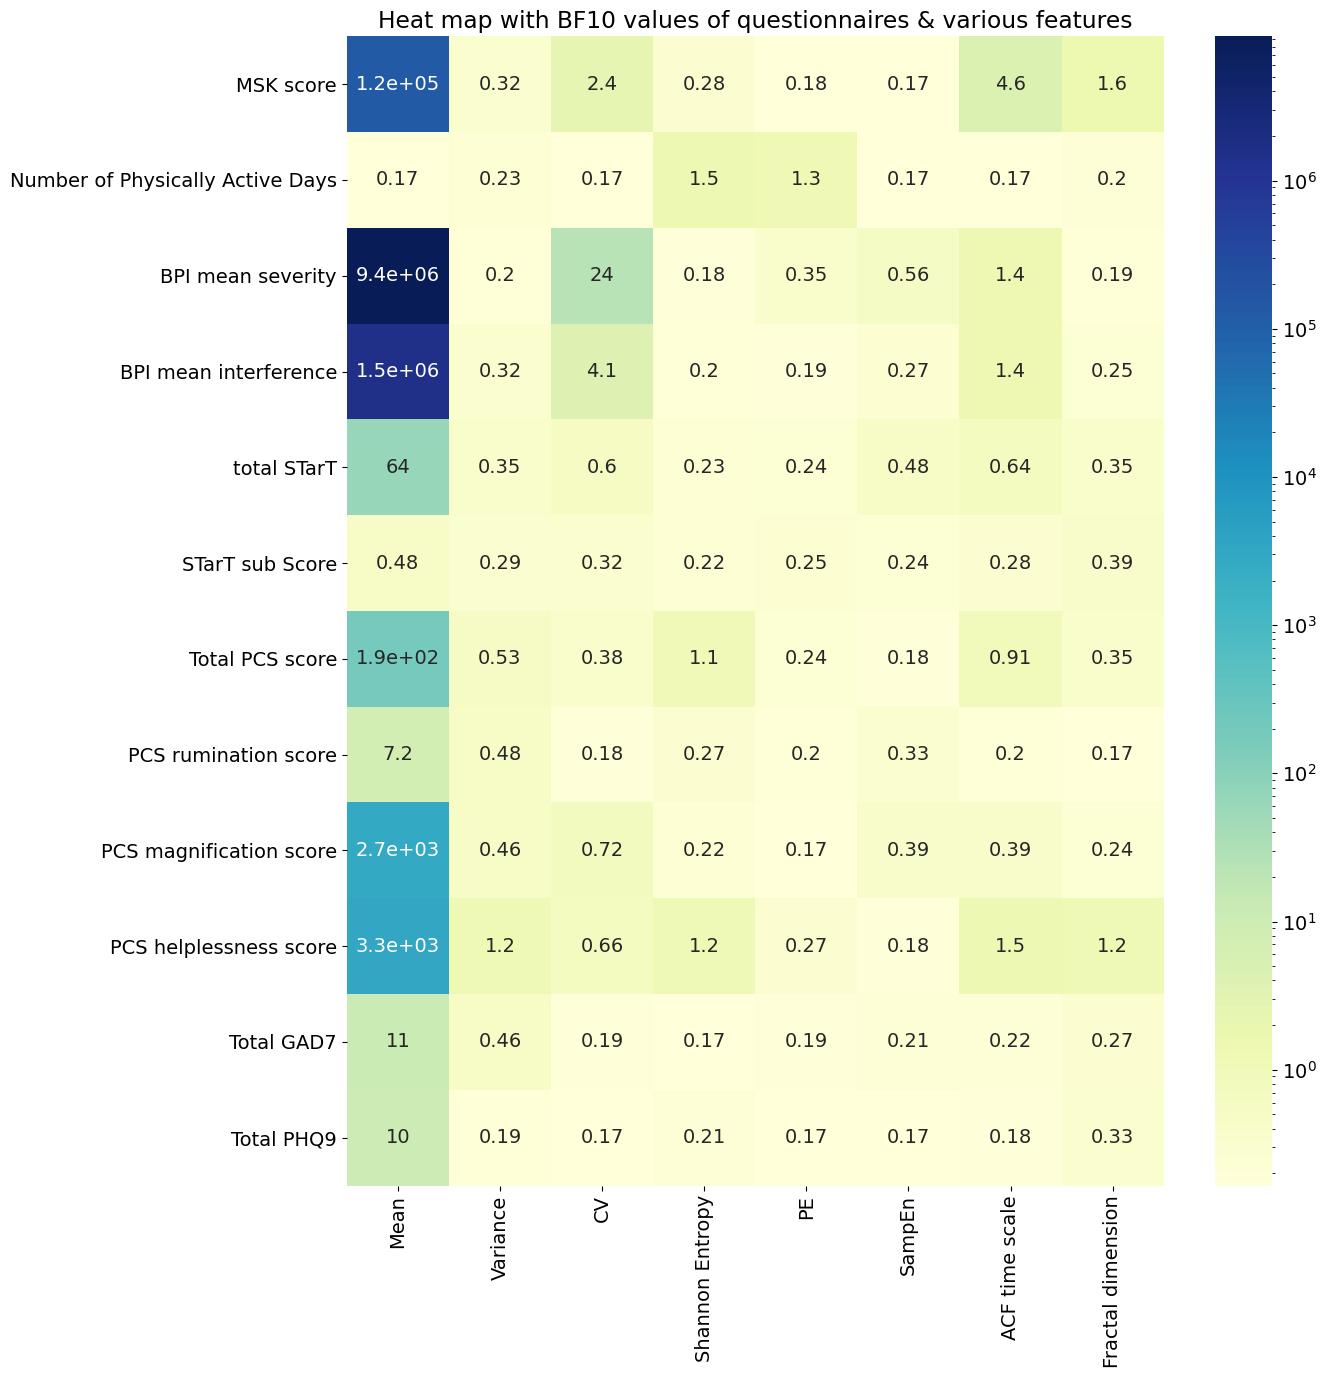

In [68]:
plt.rcParams['figure.figsize'] = (14,14)
plt.rcParams['font.size'] = '14'
total_bf = np.vstack([msk_bf, msk_lastq_bf, bpisev_bf, bpiint_bf, start_bf, startsub_bf, pcs_total_bf, pcs_rum_bf, pcs_mag_bf, pcs_help_bf, gad7_bf, phq9_bf])
sns.heatmap(total_bf, norm=LogNorm(), xticklabels=['Mean', 'Variance', 'CV', 'Shannon Entropy', 'PE', 'SampEn','ACF time scale', 'Fractal dimension'], cmap="YlGnBu", annot = True,
            yticklabels = ['MSK score', 'Number of Physically Active Days','BPI mean severity', 'BPI mean interference', 'total STarT', 'STarT sub Score', 'Total PCS score', 'PCS rumination score', 'PCS magnification score', 'PCS helplessness score', 'Total GAD7', 'Total PHQ9'])
plt.title('Heat map with BF10 values of questionnaires & various features')
plt.tight_layout()
plt.savefig('corr_heatmap.svg')

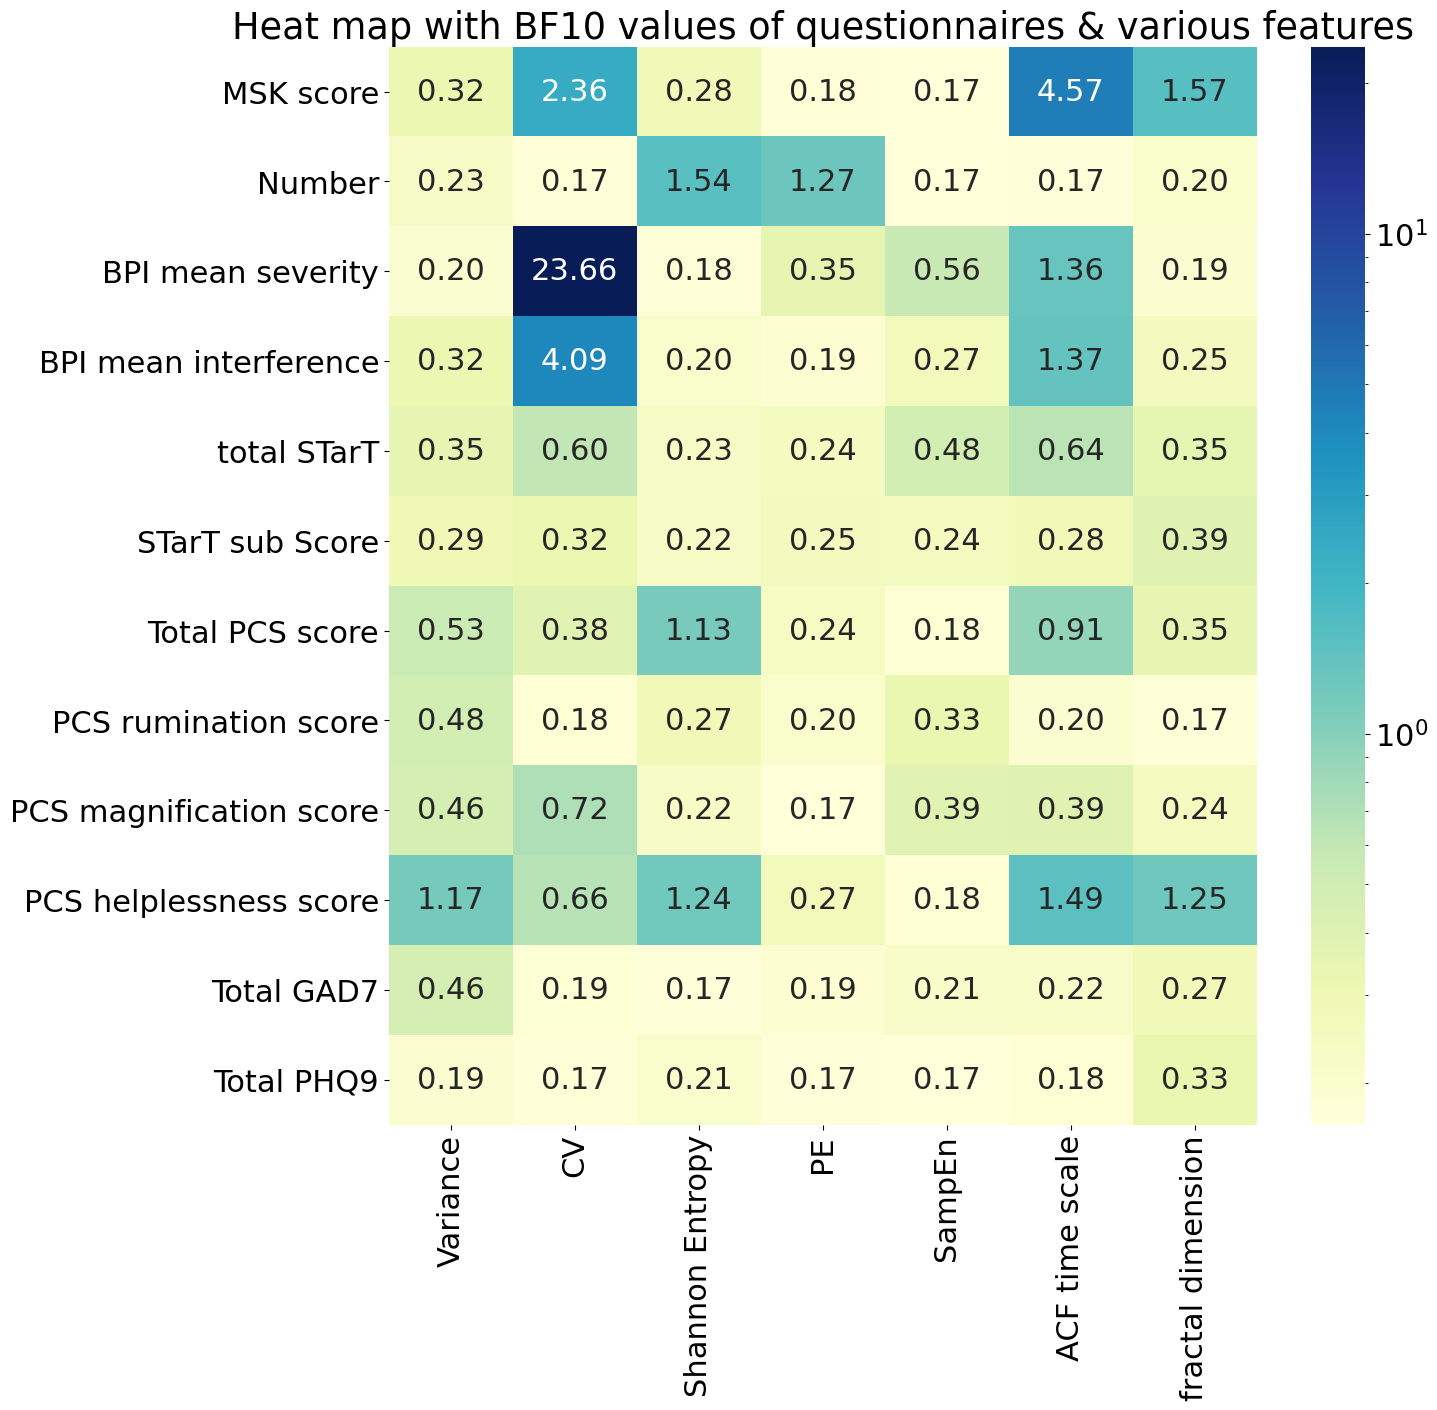

In [69]:
plt.rcParams['font.size'] = '22'
total_bf = np.vstack([msk_bf, msk_lastq_bf, bpisev_bf, bpiint_bf, start_bf, startsub_bf, pcs_total_bf, pcs_rum_bf, pcs_mag_bf, pcs_help_bf, gad7_bf, phq9_bf])
total_bf = total_bf[:,1:]
sns.heatmap(total_bf, norm=LogNorm(), fmt='.2f', xticklabels=['Variance', 'CV', 'Shannon Entropy', 'PE', 'SampEn', 'ACF time scale','fractal dimension'], cmap="YlGnBu", annot = True,
            yticklabels = ['MSK score', 'Number','BPI mean severity', 'BPI mean interference', 'total STarT', 'STarT sub Score', 'Total PCS score', 'PCS rumination score', 'PCS magnification score', 'PCS helplessness score', 'Total GAD7', 'Total PHQ9'])
plt.title('Heat map with BF10 values of questionnaires & various features')
plt.savefig('corr_heatmap.svg')

# Prediction & Confidence

In [76]:
prediction_all = data['prediction'].values
confidence_all = data['confidence'].values



# Save Day 2 Data Descriptive

In [126]:
data_dict = {'PID': participant_list_d2, 'ratings': rating_downsample_list_all, 'mean': mean_list_all, 'mean overall': mean_overall, 'mean square': mean_square_list_all, 'variance': variance_list_all, 'variance overall': var_combined_list_all, 'CV': cv_list_all, 'CV overall': cv_combined_list, 'power spectrum frequency': psd_freq_list_all, 'power spectrum weights': psd_list_all, 'permutation entropy': entropy_list_all, 'permutation entropy overall': entropy_overall, 'sample entropy': sample_entropy_list_all, 'sample entropy overall': sample_entropy_overall, 'fractal dimension': fractal_dfa_all_dllm, 'fractal dimension overall': fractal_dfa_dllm_overall, 'autocorrelation': acorr_list_all, 'stationary': stationary_list_all, 'Prediction': prediction_all, 'Confidence': confidence_all}
data_descriptive = pd.DataFrame(data_dict)
data_descriptive.to_pickle('../Data/descriptive_data/DescriptiveDataD2.pkl')

# Test-retest
## import day 1 data

In [101]:
data_d1 = pd.read_pickle('../Data/descriptive_data/DescriptiveData.pkl')
data_d1

,PID,ratings,mean,mean overall,mean square,variance,variance overall,CV,CV overall,power spectrum frequency,...,permutation entropy,permutation entropy overall,sample entropy,sample entropy overall,fractal dimension,fractal dimension overall,autocorrelation,stationary,Prediction,Confidence
0,5cf4949170036500157cd383,"[[3.9564919407818815, 3.9564919407818815, 3.95...","[4.023364438812769, 4.411823542259133, 3.50149...",3.978896,"[492.9873549692807, 604.6633814513488, 381.063...","[8.227682742548177, 21.54755039770802, 13.8273...",0.622146,"[0.13027933316225462, 0.19223016399291637, 0.1...",0.198693,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.20409498024225753, 0.20313059456558952, 0.1...",0.202387,"[0.014405336558857397, 0.0040993882003834935, ...",0.006636,"[1.4935810215800873, 1.5278356543962828, 1.579...",1.533686,"[[1.0, 0.999203085250573, 0.9980712401386508, ...","[0, 0, 0]",2.993629,2.553103
1,61605e62983592f4112241a6,"[[0.013159910945260832, 0.013159910945260832, ...","[0.1132079914424044, 0.06583122657398598, 0.50...",0.226953,"[0.6528838399444407, 0.2049749885972505, 12.29...","[0.04904312884138986, 0.0003267244178075376, 0...",0.041380,"[0.28498886370408294, 0.03995643786454877, 0.2...",0.902016,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.004119816107008897, 0.002383833898973071, 0...",0.002950,"[0.0003604135613559985, 5.30507581168075e-06, ...",0.000130,"[1.5122926216537174, 1.4876905335137005, 1.610...",1.536872,"[[1.0, 0.9950740893860458, 0.9901481787720914,...","[1, 1, 1]",0.478158,9.676871
2,5a9ea9fe1ade740001b92063,"[[5.438168051345614, 5.438168051345614, 5.4381...","[3.276876848306537, 2.5777276897041115, 3.0462...",2.966964,"[423.61310249674113, 260.17348774235177, 363.5...","[8.828064244228779, 4.039985573099263, 4.10421...",0.225833,"[0.14588854778693758, 0.12559047796240122, 0.1...",0.159307,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.47931158318029493, 0.4337799534202456, 0.56...",0.492564,"[0.022195476487129856, 0.027250297929678757, 0...",0.041812,"[1.4004653390827615, 1.5537803503902037, 1.444...",1.466170,"[[1.0, 0.9972869640268707, 0.9944868371562156,...","[1, 1, 1]",5.372540,6.275510
3,600606925db9c892b3939202,"[[0.7623176866689707, 0.7623176866689707, 0.76...","[1.0864172889547312, 1.272855474425587, 1.1394...",1.166230,"[94.67453128405339, 112.02648162715329, 79.631...","[26.424752058190744, 22.300735766445218, 3.215...",0.301141,"[0.6222355717632261, 0.4985412030649182, 0.205...",0.473946,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.1786578660608929, 0.4473927600309527, 0.045...",0.223899,"[0.0067677963618375464, 0.0020751174581086504,...",0.003234,"[1.5332533441178713, 1.5252716757064784, 1.537...",1.531844,"[[1.0, 0.9982058323035615, 0.9959312123102295,...","[1, 1, 0]",0.945233,7.556328
4,61718d5a91c07b60dcc57a8e,"[[4.342549218724408, 4.342549218724408, 4.3425...","[3.860900880575471, 3.7904203259515374, 3.2584...",3.636603,"[919.9004682071563, 866.7499813215364, 639.573...","[25.399189271241926, 4.58720524145338, 2.42407...",0.257412,"[0.16850758104571545, 0.07294229975345876, 0.0...",0.139558,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.13303514094661417, 0.08378573122519019, 0.0...",0.098146,"[0.003857753976225992, 0.0009822096201498275, ...",0.005016,"[1.527889911327674, 1.4633115539981478, 1.5389...",1.510039,"[[1.0, 0.9999331209805579, 0.9998551169776018,...","[0, 0, 0]",NaN,8.397022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,63e51e7aecab96d2000c7278,"[[4.792582115829978, 4.787828745119739, 4.7878...","[4.281806366143263, 4.604827694746724, 5.00247...",4.629702,"[1130.7246700133094, 1407.2508762256023, 1656....","[32.515044041240095, 137.24086355314012, 157.5...",1.959677,"[0.17206777792053113, 0.32872909838110503, 0.3...",0.301155,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.1207360470334362, 0.1999275305907327, 0.128...",0.149768,"[0.013774666321407

In [102]:
data_d1_in_d2 = data_d1[data_d1['PID'].isin(participant_list_d2)]
data_d1_in_d2

,PID,ratings,mean,mean overall,mean square,variance,variance overall,CV,CV overall,power spectrum frequency,...,permutation entropy,permutation entropy overall,sample entropy,sample entropy overall,fractal dimension,fractal dimension overall,autocorrelation,stationary,Prediction,Confidence
1,61605e62983592f4112241a6,"[[0.013159910945260832, 0.013159910945260832, ...","[0.1132079914424044, 0.06583122657398598, 0.50...",0.226953,"[0.6528838399444407, 0.2049749885972505, 12.29...","[0.04904312884138986, 0.0003267244178075376, 0...",0.041380,"[0.28498886370408294, 0.03995643786454877, 0.2...",0.902016,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.004119816107008897, 0.002383833898973071, 0...",0.002950,"[0.0003604135613559985, 5.30507581168075e-06, ...",0.000130,"[1.5122926216537174, 1.4876905335137005, 1.610...",1.536872,"[[1.0, 0.9950740893860458, 0.9901481787720914,...","[1, 1, 1]",0.478158,9.676871
2,5a9ea9fe1ade740001b92063,"[[5.438168051345614, 5.438168051345614, 5.4381...","[3.276876848306537, 2.5777276897041115, 3.0462...",2.966964,"[423.61310249674113, 260.17348774235177, 363.5...","[8.828064244228779, 4.039985573099263, 4.10421...",0.225833,"[0.14588854778693758, 0.12559047796240122, 0.1...",0.159307,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.47931158318029493, 0.4337799534202456, 0.56...",0.492564,"[0.022195476487129856, 0.027250297929678757, 0...",0.041812,"[1.4004653390827615, 1.5537803503902037, 1.444...",1.466170,"[[1.0, 0.9972869640268707, 0.9944868371562156,...","[1, 1, 1]",5.372540,6.275510
3,600606925db9c892b3939202,"[[0.7623176866689707, 0.7623176866689707, 0.76...","[1.0864172889547312, 1.272855474425587, 1.1394...",1.166230,"[94.67453128405339, 112.02648162715329, 79.631...","[26.424752058190744, 22.300735766445218, 3.215...",0.301141,"[0.6222355717632261, 0.4985412030649182, 0.205...",0.473946,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.1786578660608929, 0.4473927600309527, 0.045...",0.223899,"[0.0067677963618375464, 0.0020751174581086504,...",0.003234,"[1.5332533441178713, 1.5252716757064784, 1.537...",1.531844,"[[1.0, 0.9982058323035615, 0.9959312123102295,...","[1, 1, 0]",0.945233,7.556328
4,61718d5a91c07b60dcc57a8e,"[[4.342549218724408, 4.342549218724408, 4.3425...","[3.860900880575471, 3.7904203259515374, 3.2584...",3.636603,"[919.9004682071563, 866.7499813215364, 639.573...","[25.399189271241926, 4.58720524145338, 2.42407...",0.257412,"[0.16850758104571545, 0.07294229975345876, 0.0...",0.139558,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.13303514094661417, 0.08378573122519019, 0.0...",0.098146,"[0.003857753976225992, 0.0009822096201498275, ...",0.005016,"[1.527889911327674, 1.4633115539981478, 1.5389...",1.510039,"[[1.0, 0.9999331209805579, 0.9998551169776018,...","[0, 0, 0]",NaN,8.397022
6,611babe081137b57fb423693,"[[3.591822283879032, 3.998251451403716, 4.2601...","[5.50198290465129, 5.620102222658013, 6.014856...",5.712314,"[907.627573807585, 940.1698751755805, 1084.675...","[9.248977266156656, 1.6268389008433701, 0.5019...",0.177181,"[0.1014652098060393, 0.04163371629668734, 0.02...",0.073834,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.20652562133044386, 0.05062441163979635, 0.0...",0.114264,"[0.02283503107349311, 0.002747905184244892, 0....",0.008705,"[1.6192173050884442, 1.5966590737626014, 1.569...",1.595116,"[[1.0, 0.9972688540857408, 0.994470340146791, ...","[0, 1, 0]",6.833447,5.715848
8,62b33a5e37ff2b46fba512e3,"[[6.476298392110198, 6.476298392110198, 6.4762...","[7.296949275317391, 8.052259028038106, 8.60990...",7.986370,"[3179.340913792679, 3897.892642112609, 4455.28...","[14.506257128484462, 6.767063100138715, 6.4813...",0.394160,"[0.0677021051149021, 0.04170253826359444, 0.03...",0.077631,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.6372564563677843, 0.6223989712770325, 0.172...",0.477479,"[0.5450153623553934, 0.5010921234240637, 0.018...",0.354842,"[1.6646127546893847, 1.5163721960970449, 1.454

In [79]:
participant_list_d2

array(['61605e62983592f4112241a6', '5a9ea9fe1ade740001b92063',
       '600606925db9c892b3939202', '61718d5a91c07b60dcc57a8e',
       '611babe081137b57fb423693', '62b33a5e37ff2b46fba512e3',
       '615c453806ba1a372800c832', '59de4ee5d838ae0001850567',
       '6235d96c087939dba5586d97', '5af74339e19f8c00019e5bb1',
       '5f69f8a030340e0162eb8c76', '6148a15571fc73becd361f1b',
       '636a4ee9e3b42b6f65bf5032', '58eec4b09fbdde00011e95b0',
       '6103f6e09066149d3687c2bb', '5c3a4e759e794d000129a225',
       '5fc8d127db88a129e6d0130a', '6310ccbda708843d8c079b6d',
       '61268bfae35dcb011f6081b5', '5ecd36302b4d3c05d4cc1ba2',
       '62a4d721a9d118a25be1ed3f', '62d59b380be0866cf039e0ee',
       '5ba17c2d6d7a520001bfabae', '5d6e570e8c129300166dba20',
       '5944e8d4d8d2690001d0a6fa', '5c377642bc6444000133aae9',
       '5d0913ff65eb3400019cc1d8', '5bc5f36b8d83e10001724601',
       '63066fd662ffe3dc553bb8a3', '63468b3bd07050877a6beb11',
       '5e62ece11e3088084e0039b8', '62b2d042ae6609abd80

In [80]:
import pingouin as pg


In [103]:
data_d1_in_d2.columns

Index(['PID', 'ratings', 'mean', 'mean overall', 'mean square', 'variance',
       'variance overall', 'CV', 'CV overall', 'power spectrum frequency',
       'power spectrum weights', 'permutation entropy',
       'permutation entropy overall', 'sample entropy',
       'sample entropy overall', 'fractal dimension',
       'fractal dimension overall', 'autocorrelation', 'stationary',
       'Prediction', 'Confidence'],
      dtype='object')

In [159]:
mean_overall_d1 = data_d1_in_d2['mean overall'].values
var_overall_d1 = data_d1_in_d2['variance overall'].values
cv_overall_d1 = data_d1_in_d2['CV overall'].values
pe_overall_d1 = data_d1_in_d2['permutation entropy overall'].values
sampen_overall_d1 = data_d1_in_d2['sample entropy overall'].values
fractal_overall_d1 = data_d1_in_d2['fractal dimension overall'].values
mean_all_d1 = data_d1_in_d2['mean'].values
var_all_d1 = data_d1_in_d2['variance'].values
cv_all_d1 = data_d1_in_d2['CV'].values
pe_all_d1 = data_d1_in_d2['permutation entropy'].values
sampen_all_d1 = data_d1_in_d2['sample entropy'].values
fractal_all_d1 = data_d1_in_d2['fractal dimension'].values

In [127]:
data_d2 = pd.read_pickle('../Data/descriptive_data/DescriptiveDataD2.pkl')
data_d2

,PID,ratings,mean,mean overall,mean square,variance,variance overall,CV,CV overall,power spectrum frequency,...,permutation entropy,permutation entropy overall,sample entropy,sample entropy overall,fractal dimension,fractal dimension overall,autocorrelation,stationary,Prediction,Confidence
0,61605e62983592f4112241a6,"[[9.886191803050025, 9.886191803050025, 9.8861...","[0.2892971554139377, 0.6582580767939046, 0.684...",0.543944,"[16.333330528729796, 20.33853892554193, 30.249...","[12.420453487239383, 0.0002097956803377368, 8....",0.177187,"[1.7816427543892568, 0.003211741884276775, 0.6...",0.770460,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.05149072866082964, 0.0020067959828840914, 0...",0.020806,"[0.003103479548742422, 1.850798847499672e-06, ...",0.001586,"[1.6342522958771353, 1.4986811424398905, 1.615...",1.582775,"[[1.0, 0.9634604820191238, 0.923824032612251, ...","[1, 1, 0]",NaN,0.039683
1,5a9ea9fe1ade740001b92063,"[[5.5521213725589895, 5.5521213725589895, 5.55...","[6.096204235077343, 5.755748838245308, 5.76128...",5.871080,"[1435.4682115423725, 1282.5349795665675, 1282....","[2.5170501086164134, 4.167035070976989, 2.2590...",0.103070,"[0.04191121356801065, 0.05709336517749928, 0.0...",0.054749,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.2596375375025212, 0.4566419777217982, 0.483...",0.399964,"[0.013546054128184193, 0.03474497594085532, 0....",0.029934,"[1.5255592628338377, 1.5200582570188341, 1.665...",1.570335,"[[1.0, 0.998883456920563, 0.9976197070371776, ...","[0, 1, 1]",7.187027,6.262495
2,600606925db9c892b3939202,"[[0.5221738243103604, 0.5221738243103604, 0.52...","[0.545313690973717, 0.12944790413386514, 0.247...",0.307298,"[17.571981922584396, 1.0703011582918374, 3.894...","[7.770845064930385e-05, 0.09250416002922604, 0...",0.033774,"[0.002102929490679306, 0.30757871777637164, 0....",0.592602,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[-0.0, 0.10278762665567782, 0.08045526106751309]",0.061081,"[1.0765618490676154e-06, 0.012199919652111757,...",0.006629,"[1.4306652111362799, 1.522279230555014, 1.6945...",1.549168,"[[1.0, 0.9500190924761108, 0.9000381849522219,...","[1, 0, 0]",NaN,6.760240
3,61718d5a91c07b60dcc57a8e,"[[0.1497693551930024, 0.1497693551930024, 0.14...","[3.5403572882468284, 3.089249614853761, 3.3741...",3.334578,"[757.4077288805731, 575.4464884282164, 691.043...","[5.272330835545093, 4.343108736473743, 7.87684...",0.131580,"[0.08372464462281408, 0.08720532123877829, 0.1...",0.108226,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.13476320776902798, 0.30955430630801234, 0.2...",0.244107,"[0.012268458299719308, 0.06648948894510463, 0....",0.041557,"[1.559733365322928, 1.5516505762232335, 1.4252...",1.512208,"[[1.0, 0.9899825746662583, 0.9795909989315171,...","[1, 1, 1]",NaN,4.869846
4,611babe081137b57fb423693,"[[5.497523491605883, 5.9942702519138304, 6.319...","[6.92550796797901, 7.074244703343128, 7.136648...",7.151770,"[1435.232342800334, 1502.147223731195, 1529.68...","[2.230032015721913, 0.24960530939911818, 2.417...",0.124385,"[0.03944864620176509, 0.012891597727375444, 0....",0.049499,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.1594004173251454, 0.2157512060837969, 0.055...",0.147282,"[0.011415002528872896, 0.006431722560571909, 0...",0.007510,"[1.483499972822595, 1.4284810899478195, 1.5027...",1.507577,"[[1.0, 0.9929705335698062, 0.9865657022720127,...","[0, 1, 1, 0]",7.863068,6.522803
5,62b33a5e37ff2b46fba512e3,"[[3.0321732945984063, 3.0321732945984063, 3.03...","[3.019029116473245, 3.268355327215444, 2.65690...",2.981430,"[547.1494507811952, 639.6679509731943, 423.811...","[0.12947905088720124, 0.08512982783269853, 0.1...",0.067721,"[0.01538502344007655, 0.011536989101746368, 0....",0.087207,"[[0.0, 0.078125, 0.15625, 0.234375, 0.3125, 0....",...,"[0.044938224565412764, 0.0372472423824452, 0.0...",0.036214,"[0.008066429335613075, 0.0038721158528041734, ...",0.005237,"[1.6652738648603203, 1.535025122582422, 1.5774...",1.5

In [128]:
data_d2.columns

Index(['PID', 'ratings', 'mean', 'mean overall', 'mean square', 'variance',
       'variance overall', 'CV', 'CV overall', 'power spectrum frequency',
       'power spectrum weights', 'permutation entropy',
       'permutation entropy overall', 'sample entropy',
       'sample entropy overall', 'fractal dimension',
       'fractal dimension overall', 'autocorrelation', 'stationary',
       'Prediction', 'Confidence'],
      dtype='object')

In [129]:
data_d2.drop(data_d2[data_d2['PID'] == '63d79cb221c143d2c8fdc3f6'].index, inplace = True)

In [158]:
mean_overall_d2 = data_d2['mean overall'].values
var_overall_d2 = data_d2['variance overall'].values
cv_overall_d2 = data_d2['CV overall'].values
pe_overall_d2 = data_d2['permutation entropy overall'].values
sampen_overall_d2 = data_d2['sample entropy overall'].values
fractal_overall_d2 = data_d2['fractal dimension overall'].values
mean_all_d2 = data_d2['mean'].values
var_all_d2 = data_d2['variance'].values
cv_all_d2 = data_d2['CV'].values
pe_all_d2 = data_d2['permutation entropy'].values
sampen_all_d2 = data_d2['sample entropy'].values
fractal_all_d2 = data_d2['fractal dimension'].values

In [131]:
trial_mean = pd.DataFrame(zip(mean_overall_d1, mean_overall_d2))

In [133]:
len(mean_overall_d1)
len(mean_overall_d2)

56

In [140]:
print('Pearson\'s Coefficient')
print('-----')
print('mean')
print(np.corrcoef(mean_overall_d1, mean_overall_d2))
print('-----')
print('variance')
print(np.corrcoef(var_overall_d1, var_overall_d2))
print('-----')
print('CV')
print(np.corrcoef(cv_overall_d1, cv_overall_d2))
print('-----')
print('PE')
print(np.corrcoef(pe_overall_d1, pe_overall_d2))
print('-----')
print('SampEn')
print(np.corrcoef(sampen_overall_d1, sampen_overall_d2))
print('-----')
print('fractal')
print(np.corrcoef(fractal_overall_d1, fractal_overall_d2))

Pearson's Coefficient
-----
mean
[[1.         0.80140977]
 [0.80140977 1.        ]]
-----
variance
[[1.         0.57747249]
 [0.57747249 1.        ]]
-----
CV
[[1.         0.89895109]
 [0.89895109 1.        ]]
-----
PE
[[1.         0.74867538]
 [0.74867538 1.        ]]
-----
SampEn
[[1.        0.3134064]
 [0.3134064 1.       ]]
-----
fractal
[[ 1.         -0.08896736]
 [-0.08896736  1.        ]]


In [141]:
from scipy import stats
print('Pearson\'s Coefficient')
print('-----')
print('mean')
print(stats.pearsonr(mean_overall_d1, mean_overall_d2))
print('-----')
print('variance')
print(stats.pearsonr(var_overall_d1, var_overall_d2))
print('-----')
print('CV')
print(stats.pearsonr(cv_overall_d1, cv_overall_d2))
print('-----')
print('PE')
print(stats.pearsonr(pe_overall_d1, pe_overall_d2))
print('-----')
print('SampEn')
print(stats.pearsonr(sampen_overall_d1, sampen_overall_d2))
print('-----')
print('fractal')
print(stats.pearsonr(fractal_overall_d1, fractal_overall_d2))

Pearson's Coefficient
-----
mean
PearsonRResult(statistic=0.8014097741805952, pvalue=1.1804762380533307e-13)
-----
variance
PearsonRResult(statistic=0.5774724875605054, pvalue=3.1688551220892695e-06)
-----
CV
PearsonRResult(statistic=0.8989510902101575, pvalue=5.252905491240223e-21)
-----
PE
PearsonRResult(statistic=0.7486753783127198, pvalue=3.2587027233705326e-11)
-----
SampEn
PearsonRResult(statistic=0.31340640436347894, pvalue=0.018671966376397293)
-----
fractal
PearsonRResult(statistic=-0.08896735812328867, pvalue=0.5143691698170577)


## try ICC

create a df 

person, session, value

1,1,x

1,2,y

2,1,z
...

In [182]:
session_1_mean_df = pd.DataFrame({'mean': mean_overall_d1, 'participant': range(len(mean_overall_d1)), 'session': np.zeros(len(mean_overall_d1))})
session_2_mean_df = pd.DataFrame({'mean': mean_overall_d2, 'participant': range(len(mean_overall_d2)), 'session': np.ones(len(mean_overall_d2))})
mean_df = pd.concat([session_1_mean_df,session_2_mean_df])
icc_mean_overall = pg.intraclass_corr(data=mean_df, targets = 'participant', raters = 'session', ratings='mean')
icc_mean_overall.set_index('Type')
mean_all_sep_d1 = []
mean_all_participant_d1 = []
for i in range(len(mean_all_d1)):
    for j in range(len(mean_all_d1[i])):
        mean_all_sep_d1.append(mean_all_d1[i][j])
        mean_all_participant_d1.append(i)
mean_all_sep_d2 = []
mean_all_participant_d2 = []
for i in range(len(mean_all_d2)):
    for j in range(len(mean_all_d2[i])):
        mean_all_sep_d2.append(mean_all_d2[i][j])
        mean_all_participant_d2.append(i)
session_1_mean_df_all = pd.DataFrame({'mean': mean_all_sep_d1, 'participant': mean_all_participant_d1, 'session': np.zeros(len(mean_all_sep_d1))})
session_2_mean_df_all = pd.DataFrame({'mean': mean_all_sep_d2, 'participant': mean_all_participant_d2, 'session': np.ones(len(mean_all_sep_d2))})
mean_df_all = pd.concat([session_1_mean_df_all,session_2_mean_df_all])
icc_mean_all = pg.intraclass_corr(data=mean_df_all, targets = 'participant', raters = 'session', ratings='mean')
icc_mean_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.802743,9.139032,55,56,1.945720e-14,"[0.69, 0.88]"
ICC2,Single random raters,0.802596,9.070749,55,55,3.501004e-14,"[0.69, 0.88]"
ICC3,Single fixed raters,0.801405,9.070749,55,55,3.501004e-14,"[0.68, 0.88]"
ICC1k,Average raters absolute,0.890579,9.139032,55,56,1.945720e-14,"[0.81, 0.94]"
ICC2k,Average random raters,0.890489,9.070749,55,55,3.501004e-14,"[0.81, 0.94]"
ICC3k,Average fixed raters,0.889756,9.070749,55,55,3.501004e-14,"[0.81, 0.94]"


In [193]:
mean_df_all.to_csv('mean_df.csv')  

In [185]:
session_1_var_df = pd.DataFrame({'var': var_overall_d1, 'participant': range(len(var_overall_d1)), 'session': np.zeros(len(var_overall_d1))})
session_2_var_df = pd.DataFrame({'var': var_overall_d2, 'participant': range(len(var_overall_d2)), 'session': np.ones(len(var_overall_d2))})
var_df = pd.concat([session_1_var_df,session_2_var_df])
icc_var_overall = pg.intraclass_corr(data=var_df, targets = 'participant', raters = 'session', ratings='var')
icc_var_overall.set_index('Type')
var_all_sep_d1 = []
var_all_participant_d1 = []
for i in range(len(var_all_d1)):
    for j in range(len(var_all_d1[i])):
        var_all_sep_d1.append(var_all_d1[i][j])
        var_all_participant_d1.append(i)
var_all_sep_d2 = []
var_all_participant_d2 = []
for i in range(len(var_all_d2)):
    for j in range(len(var_all_d2[i])):
        var_all_sep_d2.append(var_all_d2[i][j])
        var_all_participant_d2.append(i)
session_1_var_df_all = pd.DataFrame({'var': var_all_sep_d1, 'participant': var_all_participant_d1, 'session': np.zeros(len(var_all_sep_d1))})
session_2_var_df_all = pd.DataFrame({'var': var_all_sep_d2, 'participant': var_all_participant_d2, 'session': np.ones(len(var_all_sep_d2))})
var_df_all = pd.concat([session_1_var_df_all,session_2_var_df_all])
icc_var_all = pg.intraclass_corr(data=var_df_all, targets = 'participant', raters = 'session', ratings='var')
icc_var_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.431217,2.516279,55,56,0.000377,"[0.19, 0.62]"
ICC2,Single random raters,0.451863,2.900423,55,55,0.000061,"[0.21, 0.64]"
ICC3,Single fixed raters,0.487235,2.900423,55,55,0.000061,"[0.26, 0.66]"
ICC1k,Average raters absolute,0.602588,2.516279,55,56,0.000377,"[0.32, 0.77]"
ICC2k,Average random raters,0.622460,2.900423,55,55,0.000061,"[0.35, 0.78]"
ICC3k,Average fixed raters,0.655223,2.900423,55,55,0.000061,"[0.41, 0.8]"


In [187]:
session_1_cv_df = pd.DataFrame({'cv': cv_overall_d1, 'participant': range(len(cv_overall_d1)), 'session': np.zeros(len(cv_overall_d1))})
session_2_cv_df = pd.DataFrame({'cv': cv_overall_d2, 'participant': range(len(cv_overall_d2)), 'session': np.ones(len(cv_overall_d2))})
cv_df = pd.concat([session_1_cv_df,session_2_cv_df])
icc_cv_overall = pg.intraclass_corr(data=cv_df, targets = 'participant', raters = 'session', ratings='cv')
icc_cv_overall.set_index('Type')
cv_all_sep_d1 = []
cv_all_participant_d1 = []
for i in range(len(cv_all_d1)):
    for j in range(len(cv_all_d1[i])):
        cv_all_sep_d1.append(cv_all_d1[i][j])
        cv_all_participant_d1.append(i)
cv_all_sep_d2 = []
cv_all_participant_d2 = []
for i in range(len(cv_all_d2)):
    for j in range(len(cv_all_d2[i])):
        cv_all_sep_d2.append(cv_all_d2[i][j])
        cv_all_participant_d2.append(i)
session_1_cv_df_all = pd.DataFrame({'cv': cv_all_sep_d1, 'participant': cv_all_participant_d1, 'session': np.zeros(len(cv_all_sep_d1))})
session_2_cv_df_all = pd.DataFrame({'cv': cv_all_sep_d2, 'participant': cv_all_participant_d2, 'session': np.ones(len(cv_all_sep_d2))})
cv_df_all = pd.concat([session_1_cv_df_all,session_2_cv_df_all])
icc_cv_all = pg.intraclass_corr(data=cv_df_all, targets = 'participant', raters = 'session', ratings='cv')
icc_cv_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.824833,10.417701,55,56,9.633652e-16,"[0.72, 0.89]"
ICC2,Single random raters,0.825974,11.260103,55,55,2.569106e-16,"[0.71, 0.9]"
ICC3,Single fixed raters,0.836869,11.260103,55,55,2.569106e-16,"[0.74, 0.9]"
ICC1k,Average raters absolute,0.904010,10.417701,55,56,9.633652e-16,"[0.84, 0.94]"
ICC2k,Average random raters,0.904694,11.260103,55,55,2.569106e-16,"[0.83, 0.95]"
ICC3k,Average fixed raters,0.911191,11.260103,55,55,2.569106e-16,"[0.85, 0.95]"


In [190]:
session_1_pe_df = pd.DataFrame({'pe': pe_overall_d1, 'participant': range(len(pe_overall_d1)), 'session': np.zeros(len(pe_overall_d1))})
session_2_pe_df = pd.DataFrame({'pe': pe_overall_d2, 'participant': range(len(pe_overall_d2)), 'session': np.ones(len(pe_overall_d2))})
pe_df = pd.concat([session_1_pe_df,session_2_pe_df])
icc_pe_overall = pg.intraclass_corr(data=pe_df, targets = 'participant', raters = 'session', ratings='pe')
icc_pe_overall.set_index('Type')
pe_all_sep_d1 = []
pe_all_participant_d1 = []
for i in range(len(pe_all_d1)):
    for j in range(len(pe_all_d1[i])):
        pe_all_sep_d1.append(pe_all_d1[i][j])
        pe_all_participant_d1.append(i)
pe_all_sep_d2 = []
pe_all_participant_d2 = []
for i in range(len(pe_all_d2)):
    for j in range(len(pe_all_d2[i])):
        pe_all_sep_d2.append(pe_all_d2[i][j])
        pe_all_participant_d2.append(i)
session_1_pe_df_all = pd.DataFrame({'pe': pe_all_sep_d1, 'participant': pe_all_participant_d1, 'session': np.zeros(len(pe_all_sep_d1))})
session_2_pe_df_all = pd.DataFrame({'pe': pe_all_sep_d2, 'participant': pe_all_participant_d2, 'session': np.ones(len(pe_all_sep_d2))})
pe_df_all = pd.concat([session_1_pe_df_all,session_2_pe_df_all])
icc_pe_all = pg.intraclass_corr(data=pe_df_all, targets = 'participant', raters = 'session', ratings='pe')
icc_pe_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.750051,7.001642,55,56,6.764545e-12,"[0.61, 0.85]"
ICC2,Single random raters,0.749609,6.904120,55,55,1.258322e-11,"[0.61, 0.85]"
ICC3,Single fixed raters,0.746967,6.904120,55,55,1.258322e-11,"[0.6, 0.84]"
ICC1k,Average raters absolute,0.857176,7.001642,55,56,6.764545e-12,"[0.76, 0.92]"
ICC2k,Average random raters,0.856888,6.904120,55,55,1.258322e-11,"[0.76, 0.92]"
ICC3k,Average fixed raters,0.855159,6.904120,55,55,1.258322e-11,"[0.75, 0.92]"


In [191]:
session_1_sampen_df = pd.DataFrame({'sampen': sampen_overall_d1, 'participant': range(len(sampen_overall_d1)), 'session': np.zeros(len(sampen_overall_d1))})
session_2_sampen_df = pd.DataFrame({'sampen': sampen_overall_d2, 'participant': range(len(sampen_overall_d2)), 'session': np.ones(len(sampen_overall_d2))})
sampen_df = pd.concat([session_1_sampen_df,session_2_sampen_df])
icc_sampen_overall = pg.intraclass_corr(data=sampen_df, targets = 'participant', raters = 'session', ratings='sampen')
icc_sampen_overall.set_index('Type')
sampen_all_sep_d1 = []
sampen_all_participant_d1 = []
for i in range(len(sampen_all_d1)):
    for j in range(len(sampen_all_d1[i])):
        sampen_all_sep_d1.append(sampen_all_d1[i][j])
        sampen_all_participant_d1.append(i)
sampen_all_sep_d2 = []
sampen_all_participant_d2 = []
for i in range(len(sampen_all_d2)):
    for j in range(len(sampen_all_d2[i])):
        sampen_all_sep_d2.append(sampen_all_d2[i][j])
        sampen_all_participant_d2.append(i)
session_1_sampen_df_all = pd.DataFrame({'sampen': sampen_all_sep_d1, 'participant': sampen_all_participant_d1, 'session': np.zeros(len(sampen_all_sep_d1))})
session_2_sampen_df_all = pd.DataFrame({'sampen': sampen_all_sep_d2, 'participant': sampen_all_participant_d2, 'session': np.ones(len(sampen_all_sep_d2))})
sampen_df_all = pd.concat([session_1_sampen_df_all,session_2_sampen_df_all])
icc_sampen_all = pg.intraclass_corr(data=sampen_df_all, targets = 'participant', raters = 'session', ratings='sampen')
icc_sampen_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.298190,1.849775,55,56,0.011726,"[0.04, 0.52]"
ICC2,Single random raters,0.293880,1.818148,55,55,0.014237,"[0.03, 0.52]"
ICC3,Single fixed raters,0.290314,1.818148,55,55,0.014237,"[0.03, 0.51]"
ICC1k,Average raters absolute,0.459394,1.849775,55,56,0.011726,"[0.08, 0.68]"
ICC2k,Average random raters,0.454262,1.818148,55,55,0.014237,"[0.06, 0.68]"
ICC3k,Average fixed raters,0.449990,1.818148,55,55,0.014237,"[0.06, 0.68]"


In [192]:
session_1_fractal_df = pd.DataFrame({'fractal': fractal_overall_d1, 'participant': range(len(fractal_overall_d1)), 'session': np.zeros(len(fractal_overall_d1))})
session_2_fractal_df = pd.DataFrame({'fractal': fractal_overall_d2, 'participant': range(len(fractal_overall_d2)), 'session': np.ones(len(fractal_overall_d2))})
fractal_df = pd.concat([session_1_fractal_df,session_2_fractal_df])
icc_fractal_overall = pg.intraclass_corr(data=fractal_df, targets = 'participant', raters = 'session', ratings='fractal')
icc_fractal_overall.set_index('Type')
fractal_all_sep_d1 = []
fractal_all_participant_d1 = []
for i in range(len(fractal_all_d1)):
    for j in range(len(fractal_all_d1[i])):
        fractal_all_sep_d1.append(fractal_all_d1[i][j])
        fractal_all_participant_d1.append(i)
fractal_all_sep_d2 = []
fractal_all_participant_d2 = []
for i in range(len(fractal_all_d2)):
    for j in range(len(fractal_all_d2[i])):
        fractal_all_sep_d2.append(fractal_all_d2[i][j])
        fractal_all_participant_d2.append(i)
session_1_fractal_df_all = pd.DataFrame({'fractal': fractal_all_sep_d1, 'participant': fractal_all_participant_d1, 'session': np.zeros(len(fractal_all_sep_d1))})
session_2_fractal_df_all = pd.DataFrame({'fractal': fractal_all_sep_d2, 'participant': fractal_all_participant_d2, 'session': np.ones(len(fractal_all_sep_d2))})
fractal_df_all = pd.concat([session_1_fractal_df_all,session_2_fractal_df_all])
icc_fractal_all = pg.intraclass_corr(data=fractal_df_all, targets = 'participant', raters = 'session', ratings='fractal')
icc_fractal_all.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-0.088768,0.836939,55,56,0.744932,"[-0.34, 0.18]"
ICC2,Single random raters,-0.087986,0.838045,55,55,0.742724,"[-0.34, 0.18]"
ICC3,Single fixed raters,-0.088112,0.838045,55,55,0.742724,"[-0.34, 0.18]"
ICC1k,Average raters absolute,-0.194830,0.836939,55,56,0.744932,"[-1.03, 0.3]"
ICC2k,Average random raters,-0.192949,0.838045,55,55,0.742724,"[-1.04, 0.3]"
ICC3k,Average fixed raters,-0.193253,0.838045,55,55,0.742724,"[-1.04, 0.3]"
